# imports:


In [4]:
from os import listdir,mkdir,makedirs
from os.path import isfile, join, isdir,exists
import pandas as pd
import numpy as np
from scipy import stats
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from myplots import roundup, rounddown, find_decimal_fold, percentile_cut_off, rarefaction_calc, rarefaction_plot,draw_correlation_scatter
from matplotlib.ticker import FormatStrFormatter
import cPickle as pickle
from Bio.SeqUtils import GC
import seaborn as sns
import random
from scipy.stats import pearsonr,fisher_exact
from skbio.diversity.alpha import shannon, simpson, berger_parker_d

from pop_organize import get_sample_data, get_sample_with_dfs
from SufficientStatistics.SufficientStatistics import *
from MyFunctionsShani import *
import math
from myplots import roundup, rounddown, find_decimal_fold
from skbio.stats.distance import mantel
from scipy.spatial.distance import braycurtis, pdist, euclidean


from GeneralFeaturePhenotypeInteractions.Feature_phenotype_functions import * 
from TCR_microbiome_interactions.TCR_microbiome_interactions_functions import *
from TCR_microbiome_interactions.TCR_microbiome_interactions_functions2 import *
from SampleLists.SampleFileFunctions import *
from PhenotypicData.PhenotypeGenerationFunctions import *
from CardioProject.CardioFunctions import *
from PredictionPipeline.PredictionFunctions import *
from TCR_feature_generation.SubsamplingFunctions import *

import os
from Utils import cacheOnDisk
from SegalQueue.qp import qp,fakeqp
from addloglevels import sethandlers

#ML imports:
from xgboost import XGBClassifier
import lightgbm as lgb
from collections import OrderedDict
from sklearn.model_selection import GroupKFold,StratifiedKFold, KFold
import statsmodels.formula.api as sm
from sklearn.linear_model import LogisticRegression, LinearRegression
import shap
from sklearn import metrics, preprocessing
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel,SelectKBest,chi2,mutual_info_classif,f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import *

MyPath='/net/mraid08/export/genie/Lab/Personal/ShaniBAF'

with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530','rb') as fp:
    PNP530=pickle.load(fp)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126','rb') as fp:
    Cardio126=pickle.load(fp)
PNP530Cardio126=PNP530+Cardio126

pd.set_option('display.expand_frame_repr', False)


done1
stop
stop
done1
stop
done
done
done
done
stop
stop
end of function!!!
end of function!!!


In [2]:
import time
cdate=str(time.strftime("%d%m%Y"))
cdate

'28112018'

In [401]:
import datetime
print(datetime.datetime.now())


2018-12-16 19:21:07.795751


# process feature matrix for Cardio126 only

In [ ]:
f1='%s/TCR_real_data/Predictions/featureDFs/X_withPredictedAgeGender.dat' %MyPath
X_withPredictedAgeGender=pd.read_pickle(f1)
print X_withPredictedAgeGender.shape
X_withPredictedAgeGender.head()

In [ ]:
X_withPredictedAgeGender_Cardio126=X_withPredictedAgeGender.loc[Cardio126,:]
print X_withPredictedAgeGender_Cardio126.shape

In [ ]:
X_withPredictedAgeGender_Cardio126_org,analysisDF, X_withPredictedAgeGender_Cardio126_nameAddition=process_featureDF(X_withPredictedAgeGender_Cardio126,corrThreshold=1,
        removeCorr=True,exploreDF=True,deleteConsts=True,fillnans=False)

In [ ]:
f1='%s/TCR_real_data/Predictions/featureDFs/X_withPredictedAgeGender_ANALYSIS.xlsx' %MyPath
analysisDF.to_excel(f1)

In [ ]:
dropCols=['normSeqNums_per2000_NT_0','normSeqNums_per200_AA_0','CalcifiedAorticStenosisdisease_rel_cum_freq(perc)','CalcifiedAorticStenosisdisease_rel_seq_count',
'GraftVsHostDisease_rel_cum_freq(perc)','HSV_rel_cum_freq(perc)','Leukemia_rel_cum_freq(perc)','Plasmodiumberghei_rel_cum_freq(perc)',
'J01-03_0','D01_J01-03_0','D02_J01-03_0','D01_J01-03_1','D02_J01-03_1']


In [ ]:
X_withPredictedAgeGender_Cardio126=X_withPredictedAgeGender_Cardio126.drop(dropCols,axis=1)
X_withPredictedAgeGender_Cardio126.shape

In [ ]:
f1='%s/TCR_real_data/Predictions/featureDFs/X_withPredictedAgeGender_Cardio126.dat' %MyPath
X_withPredictedAgeGender_Cardio126.to_pickle(f1)

# calculate association with all phenotypes vs. age and gender

In [7]:
f1='%s/TCR_real_data/predictions2/TargetDFs/PNP530Cardio126_AgeGender.xlsx' %MyPath
PNP530Cardio126_AgeGender=pd.read_excel(f1).set_index('BD')
Cardio126_AgeGender=PNP530Cardio126_AgeGender.loc[Cardio126,:]
Cardio126_AgeGender.shape
Cardio126_AgeGender.head()

,Gender_Male,Age
BD,,
BD1014,1,65.0
BD1068,1,57.0
BD1013,1,75.0
BD1061,1,54.0
BD1066,1,36.0


In [14]:
f1='%s/TCR_real_data/Predictions/featureDFs/X_withPredictedAgeGender_Cardio126.dat' %MyPath
X_withPredictedAgeGender_Cardio126=pd.read_pickle(f1)
X_withPredictedAgeGender_Cardio126[['Gender_Male','Age']].head()

,Gender_Male,Age
BD1014,0.608320,52.217995
BD1068,0.815595,55.117805
BD1013,0.812599,43.762936
BD1061,0.044201,52.828072
BD1066,0.921632,36.255234


In [16]:
def calc_catPhens_TCRfeatures_associations_ttest(featureDF,featureDFname,phenDF,phenDFname,FDR=0.1,testType='ttest'):
    feature_phen_ttest = pd.DataFrame()
    
    phenDF=phenDF.loc[featureDF.index,:]
    
    if phenDFname is not None:
        phenDF=pd.DataFrame(phenDF[phenDFname])
    
#     print ('featureDF shape is', featureDF.shape)
#     print ('fisrt samples in featureDF are:', featureDF.index[:4])
#     print ('phenDF shape is', phenDF.shape)
#     print ('fisrt samples in phenDF are:', phenDF.index[:4])
    
    for n,feature in enumerate(featureDF.columns.tolist()):
        featureDF[feature]=featureDF[feature].fillna(0)
        for k,phen in enumerate(phenDF.columns):
            df=pd.DataFrame()
            phen_feat_df=pd.merge(pd.DataFrame(featureDF[feature]),pd.DataFrame(phenDF[phen]),how='inner',left_index=True,right_index=True)
            data={}
            lend={}
            names=[]
            for name,group in phen_feat_df.groupby(phen):
    #             print name
                data[name]=group[feature]
                lend[name]=len(group[feature])
                names.append(name)

            if testType=='ttest':
                s,p = stats.ttest_ind(data[names[0]],data[names[1]])
            else:
                s,p = stats.mannwhitneyu(data[names[0]],data[names[1]])   
            df.loc[0,'Feature']=feature
            df.loc[0,'Phenotype']=phen
            df.loc[0,'testType']=testType
            df.loc[0,'statistics']=s
            df.loc[0,'p']=p
            df.loc[0,'n0']=lend[names[0]]
            df.loc[0,'n1']=lend[names[1]]

            feature_phen_ttest=pd.concat([feature_phen_ttest,df])
        
    nTests=len(feature_phen_ttest) 
    feature_phen_ttest=add_corrected_pValues(feature_phen_ttest,'p',nTests,FDR)
    feature_phen_ttest=feature_phen_ttest.sort_values(by='p')
    
    return feature_phen_ttest

In [19]:
phenDF=Cardio126_AgeGender
featureDF=X_withPredictedAgeGender_Cardio126.drop(['Gender_Male','Age'],axis=1)
phenDF=phenDF.loc[featureDF.index,:]
print ('featureDF shape: ',featureDF.shape)
print ('phenDF shape: ',phenDF.shape)
phenDFname='Gender_Male'

results=[]
print 'calculating associations for gender:'
for featureDFname in featureDF.columns.tolist():
    print featureDFname
    feature_Gender_ttest=calc_catPhens_TCRfeatures_associations_ttest(featureDF,featureDFname,phenDF,phenDFname)
    results.append(feature_Gender_ttest)
    
phenDFname='Age'
print 'calculating associations for age:'
for featureDFname in featureDF.columns:
    print featureDFname
    feature_Age_pearson=calc_numPhens_TCRfeatures_associations_correlation(featureDF,featureDFname,phenDF,phenDFname)
    results.append(feature_Age_pearson)
    
final_results=pd.concat(results)
print final_results.shape

    
f1='%s/TCR_real_data/CardioSamples/TCR_phenotype_relations/Feature_AgeGender_association.xlsx' %MyPath
final_results.to_excel(f1)

final_results.head()

('featureDF shape: ', (126, 393))
('phenDF shape: ', (126, 2))
calculating associations for gender:
AA count_0
AA count_1
NT count_0
NT count_1
berger_aa_0
berger_aa_1
berger_nt_0
cdr3Length_max_0
cdr3Length_max_1
cdr3Length_mean_0
cdr3Length_mean_1
cdr3Length_std_0
cdr3Length_std_1
count (templates)_max_0
count (templates)_max_1
count (templates)_mean_0
count (templates)_mean_1
count (templates)_std_0
count (templates)_std_1
d3Deletion_mean_0
d3Deletion_mean_1
d3Deletion_std_0
d3Deletion_std_1
d5Deletion_mean_0
d5Deletion_mean_1
d5Deletion_std_0
d5Deletion_std_1
frequencyCount (%)_max_0
frequencyCount (%)_max_1
frequencyCount (%)_mean_0
frequencyCount (%)_mean_1
frequencyCount (%)_std_0
frequencyCount (%)_std_1
gc_content_0
gc_content_1
jDeletion_max_0
jDeletion_max_1
jDeletion_mean_0
jDeletion_mean_1
jDeletion_std_0
jDeletion_std_1
max_nt_per_aa_0
max_nt_per_aa_1
mean_nt_per_aa_0
mean_nt_per_aa_1
n1Insertion_max_0
n1Insertion_max_1
n1Insertion_mean_0
n1Insertion_mean_1
n1Insertion_st

V06-04_0
V06-05_0
V06-06_0
V06-07_0
V06-08_0
V06-09_0
V07-02_0
V07-03_0
V07-04_0
V07-05_0
V07-06_0
V07-07_0
V07-08_0
V07-09_0
V09-01_0
V10-01_0
V10-02_0
V10-03_0
V11-01_0
V11-02_0
V11-03_0
V12-01_0
V12-02_0
V12-05_0
V13-01_0
V14-01_0
V15-01_0
V18-01_0
V19-01_0
V20-01_0
V27-01_0
V28-01_0
V30-01_0
J01-01_0
J01-02_0
J01-04_0
J01-05_0
J01-06_0
J02-01_0
J02-02_0
J02-03_0
J02-04_0
J02-05_0
J02-06_0
J02-07_0
D01_0
D02_0
V01_J02_0
V02_J01_0
V02_J02_0
V04_J01_0
V04_J02_0
V05_J01_0
V05_J02_0
V06_J01_0
V06_J02_0
V07_J01_0
V07_J02_0
V09_J01_0
V09_J02_0
V10_J01_0
V10_J02_0
V11_J01_0
V11_J02_0
V12_J01_0
V12_J02_0
V13_J01_0
V13_J02_0
V14_J01_0
V14_J02_0
V15_J01_0
V15_J02_0
V18_J01_0
V18_J02_0
V19_J01_0
V19_J02_0
V21_J01_0
V21_J02_0
V23_J01_0
V23_J02_0
V25_J01_0
V25_J02_0
V27_J01_0
V27_J02_0
V28_J01_0
V28_J02_0
V29_J01_0
V29_J02_0
V30_J01_0
V30_J02_0
D01_J01-01_0
D01_J01-02_0
D01_J01-04_0
D01_J01-05_0
D01_J01-06_0
D01_J02-01_0
D01_J02-02_0
D01_J02-03_0
D01_J02-04_0
D01_J02-05_0
D01_J02-06_0
D01_J02-07

/usr/wisdom/python/lib/python2.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



(463347, 11)


,Feature,Phenotype,Sig by bonferroni corrected pVal,corr p_values by FDR=0.1,n0,n1,p,r,sig. by FDR=0.1,statistics,testType
0,V06_J02_0,Gender_Male,0,0.171858,12.0,114.0,0.000941,NaN,0,-3.389016,ttest
0,RheumatoidArthritis_rel_cum_freq(perc),Gender_Male,0,0.171858,12.0,114.0,0.001370,NaN,0,3.274977,ttest
0,V05_J01_1,Gender_Male,0,0.171858,12.0,114.0,0.001517,NaN,0,3.243618,ttest
0,PC3,Gender_Male,0,0.171858,12.0,114.0,0.002014,NaN,0,-3.155106,ttest
0,J02-02_1,Gender_Male,0,0.171858,12.0,114.0,0.002186,NaN,0,-3.129060,ttest


## calculate associations bwtween all phenotypes and Age and Gender:

In [411]:
CardioPhenDF=pd.read_excel('%s/TCR_real_data/CardioSamples/phenotypicData/Cardio126phenAllInfo_Nov18.xlsx' %MyPath).set_index('BD')

phenDF=Cardio126_AgeGender
featureDF=CardioPhenDF
featureDFname='phenotypes'
phenDF=phenDF.loc[featureDF.index,:]
print ('featureDF shape: ',featureDF.shape)
print ('phenDF shape: ',phenDF.shape)
phenDFname='Gender_Male'

results=[]
print 'calculating associations for gender:'
# for featureDFname in featureDF.columns.tolist():
#     print featureDFname
feature_Gender_ttest=calc_catPhens_TCRfeatures_associations_ttest(featureDF,featureDFname,phenDF,phenDFname)
results.append(feature_Gender_ttest)
    
phenDFname='Age'
print 'calculating associations for age:'
# for featureDFname in featureDF.columns:
#     print featureDFname
feature_Age_pearson=calc_numPhens_TCRfeatures_associations_correlation(featureDF,featureDFname,phenDF,phenDFname)
results.append(feature_Age_pearson)
    
final_results=pd.concat(results)
print final_results.shape
final_results.head()
    
f1='%s/TCR_real_data/CardioSamples/TCR_phenotype_relations/phenotypes_AgeGender_association.xlsx' %MyPath
final_results.to_excel(f1)

('featureDF shape: ', (126, 94))
('phenDF shape: ', (126, 2))
calculating associations for gender:
calculating associations for age:
(282, 11)


/usr/wisdom/python/lib/python2.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



## calculate associations bwtween all phenotypes and all features:

In [416]:
f1='%s/TCR_real_data/Predictions/featureDFs/X_withPredictedAgeGender_Cardio126.dat' %MyPath
X_withPredictedAgeGender_Cardio126=pd.read_pickle(f1)
featureDF=X_withPredictedAgeGender_Cardio126.drop(['Gender_Male','Age'],axis=1)
featureDFname='phenotypes'

CardioPhenDF=pd.read_excel('%s/TCR_real_data/CardioSamples/phenotypicData/Cardio126phenAllInfo_Nov18.xlsx' %MyPath).set_index('BD')

results=[]
for phen in CardioPhenDF.columns:
    nCat=CardioPhenDF[phen].nunique()
    print phen,nCat
    phenDF=pd.DataFrame(CardioPhenDF[phen])
    phenDFname=phen
    if nCat>2:
        feature_Age_pearson=calc_numPhens_TCRfeatures_associations_correlation(featureDF,featureDFname,phenDF,phenDFname)
        results.append(feature_Age_pearson)
    else:
        feature_Gender_ttest=calc_catPhens_TCRfeatures_associations_ttest(featureDF,featureDFname,phenDF,phenDFname)
        results.append(feature_Gender_ttest)
    
final_results=pd.concat(results)

final_results=add_corrected_pValues(final_results,pValueColumn='p',nTests=final_results.shape[0],FDR=0.1)
f1='%s/TCR_real_data/CardioSamples/TCR_phenotype_relations/phenotypes_TCRfeature_association.xlsx' %MyPath
final_results.to_excel(f1)

print final_results.shape
final_results.head()


RegistrationCode 126
Religion 2
Hypertension 2
Dyslipidemia 2
Glucose Disorder 4
Known CAD 2
Previous Angiography 6
Previous PCI 6
Smoking Status 3
Admission Statins 2
Admission Beta Blockers 2
Admission PPI 2
Admission ACEI 2
Admission ARB 2
Admission Calcium Channel Blockers 2
Admission Metformin 2
Admission Aspirin 2
Chief Complaint 5
Admission Diagnosis 3
GRACE Score 70
Admission Systolic BP 66
Admission Diastolic BP 47
Admission Pulse Rate 50
Admission Saturation Value 10
Admission Temperature 14
Height (cm) 28
Weight (kg) 52
Hemoglobin 48
Initial Troponin 76
Maximal Troponin 114
Initial CPK 100
Maximal CPK 111
LDH 111
AST 57
Creatinine 69
eGFR by CKD-EPI 58
Glucose 83
Total Cholesterol 88
LDL 76
HDL 40
Triglycerides 96
HbA1C 41
WBC 100
PLT 97
LVEF 6
Diastolic Funcion 3
RWMA [Anterior] 3
RWMA [Lateral] 4
RWMA [Posterior] 4
RWMA [Inferior] 8
RWMA [Septal] 4
RWMA [Anteroseptal] 3
Aortic Regurgitation 5
Mitral Regurgitation 5
Tricuspid Regurgitation 4
IV Septum (mm) 10
Posterior Wall

/usr/wisdom/python/lib/python2.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



(36942, 11)


,Feature,Phenotype,Sig by bonferroni corrected pVal,corr p_values by FDR=0.1,n0,n1,p,r,sig. by FDR=0.1,statistics,testType
0,J02-02_1,RegistrationCode,0,0.627995,NaN,NaN,0.004029,-0.254508,0,NaN,pearson
0,V11_J01_1,RegistrationCode,0,0.744674,NaN,NaN,0.009919,0.228946,0,NaN,pearson
0,D02_J02-02_1,RegistrationCode,0,0.744674,NaN,NaN,0.010084,-0.228452,0,NaN,pearson
0,D02_J02-05_1,RegistrationCode,0,0.795190,NaN,NaN,0.014580,-0.217169,0,NaN,pearson
0,n2Insertion_mean_0,RegistrationCode,0,0.801367,NaN,NaN,0.016981,-0.212346,0,NaN,pearson


# predict all phenotypes using gender alone, age alone, gender+age, gender+age+features -XGB

## results:

### first run:

In [45]:
sortBy='spearman_r'
t=0.15
d1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/predictions2/Cardio126_diseasePhenotypes/XGB_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_macrof1/'
result_file=d1+'results_df.pkl'
results=pd.read_pickle(result_file)
results.head()
results[results[sortBy]>t].sort_values(by=sortBy,ascending=False)

,AUC,Coefficient_of_determination,Precision_Recall,Size,binary_threshold,f1score,f1scoreMacro,kappa,pearson_p,pearson_r,prevalence,spearman_p,spearman_r
nTemplates,NaN,0.906321,NaN,126,NaN,NaN,NaN,NaN,2.04708e-66,0.953458,NaN,1.92848e-79,0.971564
Age,NaN,0.0719939,NaN,126,NaN,NaN,NaN,NaN,0.00131336,0.28318,NaN,0.00277502,0.26439
Maximal CPK,NaN,0.0467825,NaN,126,NaN,NaN,NaN,NaN,0.00223772,0.269931,NaN,0.0113779,0.224815
PLT,NaN,-0.136948,NaN,126,NaN,NaN,NaN,NaN,0.060559,0.167675,NaN,0.0396607,0.183545
BMI,NaN,-0.0234836,NaN,126,NaN,NaN,NaN,NaN,0.179297,0.120401,NaN,0.082121,0.155485


In [46]:
sortBy='kappa'
t=0.1
results[results[sortBy]>t].sort_values(by=sortBy,ascending=False)
# ascending=False

,AUC,Coefficient_of_determination,Precision_Recall,Size,binary_threshold,f1score,f1scoreMacro,kappa,pearson_p,pearson_r,prevalence,spearman_p,spearman_r
Discharge Ticagrelor,0.498062,NaN,0.458519,126,0.5,0.413793,0.552351,0.126665,NaN,NaN,0.420635,NaN,NaN
Admission Aspirin,0.519477,NaN,0.413576,126,0.5,0.390244,0.548063,0.121339,NaN,NaN,0.404762,NaN,NaN


In [47]:
sortBy='f1scoreMacro'
t=0.5
results[results[sortBy]>t].sort_values(by=sortBy,ascending=False)
# ascending=False

,AUC,Coefficient_of_determination,Precision_Recall,Size,binary_threshold,f1score,f1scoreMacro,kappa,pearson_p,pearson_r,prevalence,spearman_p,spearman_r
Discharge Ticagrelor,0.498062,NaN,0.458519,126,0.5,0.413793,0.552351,0.126665,NaN,NaN,0.420635,NaN,NaN
Admission Aspirin,0.519477,NaN,0.413576,126,0.5,0.390244,0.548063,0.121339,NaN,NaN,0.404762,NaN,NaN
Hypertension,0.499104,NaN,0.552774,126,0.5,0.636943,0.518471,0.051255,NaN,NaN,0.563492,NaN,NaN
Religion,0.576902,NaN,0.243704,126,0.5,0.105263,0.516151,0.079106,NaN,NaN,0.134921,NaN,NaN
Admission Diagnosis mapped_STEMI,0.579995,NaN,0.567142,126,0.5,0.512000,0.515843,0.031746,NaN,NaN,0.500000,NaN,NaN


### second run:
more diverse parameters and more random search iterations

In [48]:
sortBy='spearman_r'
t=0.15
d1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/predictions2/Cardio126_diseasePhenotypes/XGB_randomSearch_50_byRepFeatPCA10percVDJ0999PredictedAgeGender_macrof1/'
result_file=d1+'results_df.pkl'
results=pd.read_pickle(result_file)
results[results[sortBy]>t].sort_values(by=sortBy,ascending=False)

,AUC,Coefficient_of_determination,Precision_Recall,Size,binary_threshold,f1score,f1scoreMacro,kappa,pearson_p,pearson_r,prevalence,spearman_p,spearman_r
nTemplates,NaN,0.927309,NaN,126,NaN,NaN,NaN,NaN,3.42338e-75,0.966622,NaN,1.49536e-81,0.973735
Admission Diagnosis,NaN,0.0743819,NaN,126,NaN,NaN,NaN,NaN,0.000580726,0.302309,NaN,0.000632497,0.300368
Age,NaN,0.0307062,NaN,126,NaN,NaN,NaN,NaN,0.0076867,0.236444,NaN,0.00718597,0.238388
Maximal CPK,NaN,0.0685353,NaN,126,NaN,NaN,NaN,NaN,0.00124292,0.284515,NaN,0.0339902,0.189059
Diastolic Funcion,NaN,0.00432158,NaN,126,NaN,NaN,NaN,NaN,0.11564,0.140868,NaN,0.0373636,0.185693


In [49]:
sortBy='kappa'
t=0.1
results[results[sortBy]>t].sort_values(by=sortBy,ascending=False)
# ascending=False

,AUC,Coefficient_of_determination,Precision_Recall,Size,binary_threshold,f1score,f1scoreMacro,kappa,pearson_p,pearson_r,prevalence,spearman_p,spearman_r


In [50]:
sortBy='f1scoreMacro'
t=0.5
results[results[sortBy]>t].sort_values(by=sortBy,ascending=False)
# ascending=False

,AUC,Coefficient_of_determination,Precision_Recall,Size,binary_threshold,f1score,f1scoreMacro,kappa,pearson_p,pearson_r,prevalence,spearman_p,spearman_r
Hypertension,0.531370,NaN,0.602224,126,0.5,0.641026,0.528846,0.069866,NaN,NaN,0.563492,NaN,NaN
Admission Aspirin,0.561830,NaN,0.492107,126,0.5,0.373626,0.509795,0.027620,NaN,NaN,0.404762,NaN,NaN
Discharge Prasugrel,0.527167,NaN,0.451799,126,0.5,0.373626,0.509795,0.022857,NaN,NaN,0.388889,NaN,NaN
Admission Diagnosis mapped_STEMI,0.565130,NaN,0.604401,126,0.5,0.523077,0.507440,0.015873,NaN,NaN,0.500000,NaN,NaN
Discharge Clopidogrel,0.547325,NaN,0.163373,126,0.5,0.095238,0.506494,0.056738,NaN,NaN,0.142857,NaN,NaN
Chief Complaint mapped_anginal pain,0.573113,NaN,0.866489,126,0.5,0.917749,0.506494,0.081351,NaN,NaN,0.841270,NaN,NaN
Dyslipidemia,0.490738,NaN,0.713400,126,0.5,0.826923,0.504371,0.076923,NaN,NaN,0.722222,NaN,NaN


## selected parameters:

### both  run

In [57]:
pd.set_option('display.expand_frame_repr', False)
d1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/predictions2/Cardio126_diseasePhenotypes/XGB_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_macrof1/'
d2='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/predictions2/Cardio126_diseasePhenotypes/XGB_randomSearch_50_byRepFeatPCA10percVDJ0999PredictedAgeGender_macrof1/'       
d_list=[d1,d2]
target_list=['nTemplates','Age','PLT','BMI','Gender_Male','Maximal CPK','Maximal Troponin','Admission Diagnosis','Admission Diagnosis mapped_STEMI',
                 'Diastolic Funcion','Discharge Prasugrel','Discharge Clopidogrel', 'Discharge Ticagrelor','Religion']

for k in target_list:
    print k
    for n,d in enumerate(d_list):
        print n
        selected_model_params_file=d+'selected_model_params.pkl'
        selected_model_params=pd.read_pickle(selected_model_params_file)
        try:
            print selected_model_params[k]
        except:
            print 'couldnt get parameters for this phenotype'


nTemplates
0
    gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1       0           0.05          1           600          5        0.5
2       1           0.01          1          1200          1        0.5
3       5           0.05          3           400          0        0.7
4       1           0.05          1          1400          5        0.7
5       5           0.01          7           600          0        0.5
6       0           0.05          1           800          5        0.5
7       1           0.10          1           600          1        0.7
8       5           0.01          1          1400          5        0.7
9       1           0.05          1           800          1        0.7
10      0           0.01          7          1000          5        0.5
1
    gamma  learning_rate  max_depth  min_child_weight  n_estimators  reg_alpha  subsample
1       5           0.05          1                 3           800          0        0.9
2       5    

    gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1       0          0.005          1           400          1        0.5
2       5          0.005          1           600          0        0.5
3       5          0.005          5           400          0        0.7
4       0          0.005          3           400          5        0.5
5       1          0.005          3           400          5        0.5
6       1          0.005          5           400          5        0.7
7       0          0.010          7           600          0        0.5
8       1          0.005          7           400          0        0.7
9       5          0.005          1          1000          5        0.5
10      0          0.005          1           400          0        0.5
1
    gamma  learning_rate  max_depth  min_child_weight  n_estimators  reg_alpha  subsample
1       0          0.010          7                 1           200          5        0.7
2       1          0.005  

    gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1       0          0.050          7           800          0        0.7
2       0          0.050          5          1000          0        0.7
3       0          0.010          3          1600          0        0.7
4       0          0.050          3           600          1        0.7
5       1          0.100          1          1200          0        0.7
6       0          0.050          9          1600          1        0.7
7       1          0.050          5           400          1        0.7
8       0          0.100          5          1600          0        0.7
9       5          0.010          1          1000          0        0.7
10      1          0.005          5          1600          5        0.5
1
    gamma  learning_rate  max_depth  min_child_weight  n_estimators  reg_alpha  subsample
1       0          0.005          7                 1          1400          0        0.7
2      10          0.100  

# predict all phenotypes using gender alone, age along, gender+age, gender+age+features -LINEAR REGRESSION

## generate seperate tables for linearReg and logReg:

In [97]:
Yfile='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/phenotypicData/Cardio126phenAllInfo_Nov18'
Y=pd.read_pickle(Yfile)
Y=Y.drop('RegistrationCode',axis=1)

print Y.shape
Y.head()

(126, 93)


,Religion,Hypertension,Dyslipidemia,Glucose Disorder,Known CAD,Previous Angiography,Previous PCI,Smoking Status,Admission Statins,Admission Beta Blockers,...,nTemplates,PreviousPCImapped,PCI_binary,LVEFmapped,Smoking Status mapped_Past,Smoking Status mapped_Yes,Admission Diagnosis mapped_NSTEMI,Admission Diagnosis mapped_STEMI,Chief Complaint mapped_anginal pain,Chief Complaint mapped_atypical pain
BD,,,,,,,,,,,,,,,,,,,,,
BD950,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,...,14426.0,0.0,0.0,1.0,0,0,1,0,0,0
BD951,1.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,...,6955.0,0.0,0.0,1.0,1,0,0,1,1,0
BD952,1.0,0.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0,...,19832.0,0.0,0.0,1.0,0,1,0,0,1,0
BD953,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,4318.0,0.0,0.0,1.0,0,1,1,0,0,1
BD955,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,4239.0,0.0,0.0,1.0,0,1,1,0,0,1


In [98]:
Y['PreviousPCImapped'].value_counts()

0.0    108
2.0     15
Name: PreviousPCImapped, dtype: int64

In [106]:
Y_nameAddition

'_noCorr1_noConsts'

In [108]:
Y_org,YanalysisDF, Y_nameAddition=process_featureDF(Y,corrThreshold=1,
        removeCorr=True,exploreDF=True,deleteConsts=True,fillnans=False)

YANALYSISfile='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/phenotypicData/Cardio126phenAllInfo_Nov18\
ANALYSIS.xlsx'

YanalysisDF.to_excel(YANALYSISfile)

removing all columns correlated to other column by r=1 or more
TCR feature DF shape after loading and before any removal  is 126_93
removing feature columns with less than 5 samples that are not nan...
[]
number of such columns is 0
TCRfeatureDF shape after removing all columns that dont have at least 5 valid values is 126_93
TCRfeatureDF2 shape before dropping highly correlated columns=126_93
filtering out columns with correlation larger than 1
TCRfeatureDF3 shape after dropping highly correlated columns=126_93
colToDrop list length with repeats: 0
colToDrop list length without repeats: 0
colToDrop list length without repeats and with nan columns: 0
[]
exploring feature df...
(126, 93)
deleting constant variables...
constant variables are: []
featureDF shape before constant features removal is 126_93
Final featureDF shape  is 126_93
end of function!


In [101]:
YanalysisDF.head()

,number of Nans,number of 9999s,number of categories,columns,topValue,topValueFrac,type,total nans,Type
0,1.0,0.0,2.0,Religion,1.0,0.864,float64,1.0,binary
1,1.0,0.0,2.0,Hypertension,1.0,0.560,float64,1.0,binary
2,1.0,0.0,2.0,Dyslipidemia,1.0,0.720,float64,1.0,binary
3,1.0,0.0,4.0,Glucose Disorder,0.0,0.528,float64,1.0,categorial
4,1.0,0.0,2.0,Known CAD,0.0,0.672,float64,1.0,binary


In [109]:
# GEENRATE CONTINOUS TARGET FILE:
contTargetsDF=YanalysisDF[(YanalysisDF['number of categories']>2) & (YanalysisDF['type']!=object)]
contTargets=contTargetsDF['columns'].tolist()
finalContTargets=[x for x in contTargets if x in Y.columns]
print len(finalContTargets)
print finalContTargets

Y_cont=Y[finalContTargets]
print Y_cont.shape

YcontFile='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/phenotypicData/Cardio126phenAllInfo_Nov18_cont.xlsx'
Y_cont.to_excel(YcontFile)


60
[u'Glucose Disorder', u'Previous Angiography', u'Previous PCI', u'Smoking Status', u'Chief Complaint', u'Admission Diagnosis', u'GRACE Score', u'Admission Systolic BP', u'Admission Diastolic BP', u'Admission Pulse Rate', u'Admission Saturation Value', u'Admission Temperature', u'Height (cm)', u'Weight (kg)', u'Hemoglobin', u'Initial Troponin', u'Maximal Troponin', u'Initial CPK', u'Maximal CPK', u'LDH', u'AST', u'Creatinine', u'eGFR by CKD-EPI', u'Glucose', u'Total Cholesterol', u'LDL', u'HDL', u'Triglycerides', u'HbA1C', u'WBC', u'PLT', u'Diastolic Funcion', u'RWMA [Anterior]', u'RWMA [Lateral]', u'RWMA [Posterior]', u'RWMA [Inferior]', u'RWMA [Septal]', u'RWMA [Anteroseptal]', u'Aortic Regurgitation', u'Mitral Regurgitation', u'Tricuspid Regurgitation', u'IV Septum (mm)', u'Posterior Wall (mm)', u'D1 Disease', u'Distal LM Disease', u'Ostial LAD Disease', u'Proximal LAD Disease', u'Ostial CX Disease', u'Proximal CX Disease', u'Distal CX Disease', u'Ostial RCA Disease', u'Proximal R

In [110]:
# GEENRATE BINARY TARGET FILE:
binaryTargetsDF=YanalysisDF[YanalysisDF['number of categories']==2]
binaryTargets=binaryTargetsDF['columns'].tolist()
finalbinaryTargets=[x for x in binaryTargets if x in Y.columns]
print len(finalbinaryTargets)
print finalbinaryTargets

Y_binary=Y[finalbinaryTargets]
print Y_binary.shape

YbinaryFile='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/phenotypicData/Cardio126phenAllInfo_Nov18_binary.xlsx'
Y_binary.to_excel(YbinaryFile)

32
[u'Religion', u'Hypertension', u'Dyslipidemia', u'Known CAD', u'Admission Statins', u'Admission Beta Blockers', u'Admission PPI', u'Admission ACEI', u'Admission ARB', u'Admission Calcium Channel Blockers', u'Admission Metformin', u'Admission Aspirin', u'MAC', u'Discharge Clopidogrel', u'Discharge Ticagrelor', u'Discharge Prasugrel', u'Discharge ACEI', u'Discharge ARB', u'Discharge Beta Blockes', u'Discharge Calcium Channel Blockers', u'Discharge PPI', u'Discharge Insulin', u'Discharge Merformin', 'PreviousPCImapped', 'PCI_binary', 'LVEFmapped', 'Smoking Status mapped_Past', 'Smoking Status mapped_Yes', 'Admission Diagnosis mapped_NSTEMI', 'Admission Diagnosis mapped_STEMI', 'Chief Complaint mapped_anginal pain', 'Chief Complaint mapped_atypical pain']
(126, 32)


In [169]:
# GEENRATE reverse BINARY TARGET FILE:
Y_revBinary=Y_binary.copy()
Y_revBinary=(Y_revBinary<1).astype(int)

print Y_revBinary.shape

print Y_binary.iloc[:5,:5]
print Y_revBinary.iloc[:5,:5]

YrevbinaryFile='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/phenotypicData/\
Cardio126phenAllInfo_Nov18_revBinary.xlsx'
Y_revBinary.to_excel(YrevbinaryFile)

(126, 32)
       Religion  Hypertension  Dyslipidemia  Known CAD  Admission Statins
BD                                                                       
BD950       1.0           1.0           1.0        0.0                1.0
BD951       1.0           0.0           0.0        0.0                0.0
BD952       1.0           0.0           1.0        0.0                1.0
BD953       1.0           0.0           0.0        0.0                0.0
BD955       1.0           1.0           1.0        0.0                1.0
       Religion  Hypertension  Dyslipidemia  Known CAD  Admission Statins
BD                                                                       
BD950         0             0             0          1                  0
BD951         0             1             1          1                  1
BD952         0             1             0          1                  0
BD953         0             1             1          1                  1
BD955         0             

In [183]:
Y_revBinary['PreviousPCImapped'].value_counts()

1    108
0     18
Name: PreviousPCImapped, dtype: int64

In [182]:
Y_binary['PreviousPCImapped'].value_counts()

0.0    108
2.0     15
Name: PreviousPCImapped, dtype: int64

In [111]:
# GEENRATE multiclass TARGET FILE:
multiclassTargetsDF=YanalysisDF[(YanalysisDF['number of categories']>2) & (YanalysisDF['number of categories']<7)]
multiclassTargets=multiclassTargetsDF['columns'].tolist()
finalmulticlassTargets=[x for x in multiclassTargets if x in Y.columns]
print len(finalmulticlassTargets)
print finalmulticlassTargets

Y_multiclass=Y[finalmulticlassTargets]
print Y_multiclass.shape

YmulticlassFile='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/phenotypicData/Cardio126phenAllInfo_Nov18_multiclass.xlsx'
Y_multiclass.to_excel(YmulticlassFile)

21
[u'Glucose Disorder', u'Previous Angiography', u'Previous PCI', u'Smoking Status', u'Chief Complaint', u'Admission Diagnosis', u'LVEF', u'Diastolic Funcion', u'RWMA [Anterior]', u'RWMA [Lateral]', u'RWMA [Posterior]', u'RWMA [Septal]', u'RWMA [Anteroseptal]', u'Aortic Regurgitation', u'Mitral Regurgitation', u'Tricuspid Regurgitation', u'Distal LM Disease', u'Ostial LAD Disease', u'Ostial RCA Disease', u'Intervention following Angiography', u'ST Resolution']
(126, 21)


In [112]:
for col in Y_multiclass.columns:
    print col
    print  Y_multiclass[col].dtype
    print Y_multiclass[col].value_counts(dropna=False)

Glucose Disorder
float64
 0.0    66
 2.0    41
 3.0    17
NaN      1
 1.0     1
Name: Glucose Disorder, dtype: int64
Previous Angiography
float64
 0.0    84
 1.0    20
 2.0     8
 3.0     7
 4.0     5
NaN      1
 6.0     1
Name: Previous Angiography, dtype: int64
Previous PCI
float64
 0.0    89
 1.0    19
 2.0     9
 4.0     3
 3.0     3
NaN      2
 5.0     1
Name: Previous PCI, dtype: int64
Smoking Status
float64
 0.0    51
 1.0    42
 2.0    31
NaN      2
Name: Smoking Status, dtype: int64
Chief Complaint
float64
 1.0    106
 2.0     12
 4.0      3
 5.0      3
NaN       1
 3.0      1
Name: Chief Complaint, dtype: int64
Admission Diagnosis
float64
 3.0    63
 2.0    43
 1.0    19
NaN      1
Name: Admission Diagnosis, dtype: int64
LVEF
object
 0.0    60
 6.0    20
 1.0    18
 2.0    14
 3.0    12
 4.0     1
NaN      1
Name: LVEF, dtype: int64
Diastolic Funcion
float64
 0.0    62
 1.0    51
NaN     12
 3.0     1
Name: Diastolic Funcion, dtype: int64
RWMA [Anterior]
float64
 1.0    96
 3

## get results for binary phenotypes:

In [76]:
sortBy='kappa'
t=0.1
cols=['AUC','Precision_Recall','kappa','f1score','f1scoreMacro','prevalence']


d1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/predictions2/Cardio126_diseasePhenotypes/\
binary_lin_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro/'
result_file=d1+'results_df.pkl'
results=pd.read_pickle(result_file)
results[results[sortBy]>t].sort_values(by=sortBy,ascending=False)[cols]

,AUC,Precision_Recall,kappa,f1score,f1scoreMacro,prevalence
MAC,0.693878,0.224150,0.193705,0.327273,0.569728,0.111111
Religion,0.547760,0.220202,0.184843,0.275862,0.590846,0.134921
Hypertension,0.628169,0.644390,0.168693,0.653061,0.583673,0.563492
Discharge Prasugrel,0.548900,0.383950,0.143627,0.504673,0.569578,0.388889
Admission ARB,0.536508,0.199356,0.130841,0.279070,0.565372,0.166667
Discharge PPI,0.558140,0.702555,0.127182,0.695122,0.563470,0.658730
Admission Aspirin,0.552418,0.430631,0.121611,0.490566,0.560352,0.404762


In [77]:
sortBy='AUC'
t=0.6

results[results[sortBy]>t].sort_values(by=sortBy,ascending=False)[cols]

,AUC,Precision_Recall,kappa,f1score,f1scoreMacro,prevalence
MAC,0.693878,0.22415,0.193705,0.327273,0.569728,0.111111
Hypertension,0.628169,0.64439,0.168693,0.653061,0.583673,0.563492


In [79]:
sortBy='f1scoreMacro'
t=0.5

results[results[sortBy]>t].sort_values(by=sortBy,ascending=False)[cols]

,AUC,Precision_Recall,kappa,f1score,f1scoreMacro,prevalence
Religion,0.547760,0.220202,0.184843,0.275862,0.590846,0.134921
Hypertension,0.628169,0.644390,0.168693,0.653061,0.583673,0.563492
MAC,0.693878,0.224150,0.193705,0.327273,0.569728,0.111111
Discharge Prasugrel,0.548900,0.383950,0.143627,0.504673,0.569578,0.388889
Admission ARB,0.536508,0.199356,0.130841,0.279070,0.565372,0.166667
Discharge PPI,0.558140,0.702555,0.127182,0.695122,0.563470,0.658730
Admission Aspirin,0.552418,0.430631,0.121611,0.490566,0.560352,0.404762
Discharge Merformin,0.550864,0.274802,0.078232,0.346667,0.534915,0.253968


In [80]:
pd.set_option('display.expand_frame_repr', False)
d1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/predictions2/Cardio126_diseasePhenotypes/\
binary_lin_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro/'
      
target_list=['MAC','Religion','Hypertension','Discharge Prasugrel','Discharge PPI','Admission Aspirin','Admission ARB']

for k in target_list:
    print k
    selected_model_params_file=d1+'selected_model_params.pkl'
    selected_model_params=pd.read_pickle(selected_model_params_file)
    try:
        print selected_model_params[k]
    except:
        print 'couldnt get parameters for this phenotype'

MAC
          C penalty
1     0.001      l1
2     0.001      l1
3   100.000      l1
4     5.000      l1
5     1.000      l1
6   100.000      l1
7     1.000      l1
8     1.000      l1
9    10.000      l1
10    0.001      l1
Religion
      C penalty
1     1      l1
2    50      l1
3    10      l1
4    10      l1
5     1      l1
6     1      l1
7    10      l1
8     1      l1
9   100      l1
10    5      l1
Hypertension
        C penalty
1   0.100      l1
2   0.100      l1
3   0.001      l2
4   0.100      l1
5   0.001      l2
6   0.100      l1
7   0.100      l1
8   0.100      l1
9   0.100      l1
10  0.100      l1
Discharge Prasugrel
        C penalty
1   0.001      l2
2   0.001      l2
3   0.001      l2
4   0.001      l2
5   0.001      l2
6   0.010      l2
7   0.001      l2
8   0.100      l1
9   0.100      l1
10  0.010      l2
Discharge PPI
      C penalty
1   100      l1
2    50      l2
3     1      l1
4    50      l1
5     1      l1
6   100      l1
7   100      l1
8     5      l1
9   

## get results for CONTINUOUS phenotypes:

In [122]:
sortBy='pearson_r'
t=0.05
# cols=['AUC','Precision_Recall','kappa','f1score','f1scoreMacro','prevalence']


d1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/predictions2/Cardio126_diseasePhenotypes/\
lin_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpar/'
result_file=d1+'results_df.pkl'
results=pd.read_pickle(result_file)
results[results[sortBy]>t].sort_values(by=sortBy,ascending=False)

,Size,Coefficient_of_determination,pearson_r,pearson_p,spearman_r,spearman_p,explained_variance_score
nTemplates,126,0.960568,0.980537,1.56494e-89,0.984498,1.31679e-95,0.960575
Age,126,0.175317,0.419053,1.04124e-06,0.414902,1.36255e-06,0.175545
Initial CPK,126,0.0322192,0.202787,0.0227679,0.223412,0.0119145,0.032594
Maximal CPK,126,-0.0144048,0.188175,0.0348501,0.150671,0.0921726,-0.014150
Maximal Troponin,126,-0.532416,0.143839,0.108084,0.28141,0.00141244,-0.532073
Admission Diagnosis,126,-0.015942,0.102306,0.254314,0.0805966,0.369645,-0.015935


In [123]:
sortBy='pearson_r'
t=-99999
# cols=['AUC','Precision_Recall','kappa','f1score','f1scoreMacro','prevalence']


d1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/predictions2/Cardio126_diseasePhenotypes/\
lin_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpar/'
result_file=d1+'results_df.pkl'
results=pd.read_pickle(result_file)
results[results[sortBy]>t].sort_values(by=sortBy)

,Size,Coefficient_of_determination,pearson_r,pearson_p,spearman_r,spearman_p,explained_variance_score
Tricuspid Regurgitation,126,-0.0266306,-0.341217,9.2301e-05,-0.324495,0.000209747,-0.026630
Intervention following Angiography,126,-0.0285649,-0.340551,9.54527e-05,-0.312724,0.000363592,-0.028564
GRACE Score,126,-0.0637278,-0.327023,0.000185823,-0.324415,0.000210549,-0.063683
Ostial CX Disease,126,-0.0253028,-0.325148,0.000203313,-0.261956,0.00304595,-0.025303
Proximal LAD Disease,126,-0.023086,-0.314266,0.000338756,-0.280615,0.00145909,-0.023086
Proximal CX Disease,126,-0.0210161,-0.301997,0.000588786,-0.25389,0.00412199,-0.021015
IV Septum (mm),126,-0.0205607,-0.300814,0.000620237,-0.323053,0.000224646,-0.020561
Chief Complaint,126,-0.0207244,-0.298358,0.000690536,-0.266054,0.00260262,-0.020724
HbA1C,126,-0.0199152,-0.290697,0.000959459,-0.222396,0.0123169,-0.019915
Previous Angiography,126,-0.0200787,-0.290127,0.000982839,-0.297125,0.000728528,-0.020078


In [121]:
pd.set_option('display.expand_frame_repr', False)
d1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/predictions2/Cardio126_diseasePhenotypes/\
lin_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpar/'

      
target_list=['Age','Initial CPK','Maximal CPK','Maximal Troponin','Admission Diagnosis']

for k in target_list:
    print k
    selected_model_params_file=d1+'selected_model_params.pkl'
    selected_model_params=pd.read_pickle(selected_model_params_file)
    try:
        print selected_model_params[k]
    except:
        print 'couldnt get parameters for this phenotype'

Age
    alpha
1       1
2       1
3       1
4       1
5       1
6       1
7       1
8       1
9       1
10      1
Initial CPK
    alpha
1     100
2     100
3     100
4     100
5     100
6     100
7     100
8     100
9     100
10    100
Maximal CPK
    alpha
1     100
2     100
3     100
4     100
5     100
6     100
7     100
8     100
9     100
10    100
Maximal Troponin
    alpha
1     100
2     100
3     100
4     100
5     100
6     100
7     100
8     100
9     100
10    100
Admission Diagnosis
    alpha
1     0.1
2     0.1
3     0.1
4     0.1
5     1.0
6     1.0
7     1.0
8     0.1
9     0.1
10    0.1


# compare prediction results for binary targets:

In [128]:
binaryDList=[
    'ChiefComplaintmapped_anginalpain_logReg100_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByAUC',
#    'allCardioPhens_randomSearch_25_byNewX_kappa',
    'AdmissionAspirinBetaBlockersDischargeMerformin_XGB100_randomSearch_25_byNewX_AUC',
    'AdmissionAspirinBetaBlockersDischargeMerformin_XGB100_randomSearch_25_byNewX_kappa',
    'allCardioPhens_XGB100_randomSearch_25_byNewX_kappa',
    'Cardio126bin_logReg50_gridSearch_byNewX_optByKappa',
    'XGB_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_macrof1',
             'XGB_randomSearch_50_byRepFeatPCA10percVDJ0999PredictedAgeGender_macrof1',
       'XGB_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_kappa',
#              'XGBrevBinary_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_kappa',
             'XGBbinary20_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_kappa',
             'XGBbinary20Strat_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_kappa',
#              'XGBrevBinary20_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_kappa',
#            'XGBrevBinary50_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_kappa',
          'XGBbinary50_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_kappa',
              'logReg_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByKappa',
            'logRegStrat_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByKappa',
             'logReg10Strat_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByKappa',
            'logReg20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByKappa',
             'logReg20Strat_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByKappa',
            'logReg50_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByKappa',
            'logReg50Strat_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByKappa',
            'logReg100Strat_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByKappa']
#              'logRegRevBinary_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByKappa',

## get results

In [129]:
sortBy='kappa'
t=0.19
ascending=False
cols=['AUC','Precision_Recall','kappa','f1score','f1scoreMacro','prevalence']

print 'Sort by %s, threshold=%s' %(sortBy,t)
print '************************'
print ''

for d1 in binaryDList:
    print d1
    print '-----------'
    gDIR='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/Cardio126_diseasePhenotypes/'
    result_file=gDIR+d1+'/results_df.pkl'
    results=pd.read_pickle(result_file)
    print results[results[sortBy]>t].sort_values(by=sortBy,ascending=ascending)[cols]
    print ''
    print ''

Sort by kappa, threshold=0.19
************************

ChiefComplaintmapped_anginalpain_logReg100_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByAUC
-----------
                                       AUC  Precision_Recall     kappa   f1score  f1scoreMacro  prevalence
ChiefComplaintmapped_anginalpain  0.739151          0.925598  0.318029  0.854271      0.653551     0.84127


AdmissionAspirinBetaBlockersDischargeMerformin_XGB100_randomSearch_25_byNewX_AUC
-----------
                       AUC  Precision_Recall     kappa  f1score  f1scoreMacro  prevalence
AdmissionAspirin  0.652026          0.588365  0.242002      0.5      0.615854    0.404762


AdmissionAspirinBetaBlockersDischargeMerformin_XGB100_randomSearch_25_byNewX_kappa
-----------
                            AUC  Precision_Recall     kappa   f1score  f1scoreMacro  prevalence
AdmissionBetaBlockers  0.686883          0.511040  0.206667  0.346154      0.588077    0.285714
AdmissionAspirin       0.641830          0

IOError: [Errno 2] No such file or directory: '/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/Cardio126_diseasePhenotypes/logReg20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByKappa/results_df.pkl'

In [130]:
sortBy='AUC'
t=0.6
ascending=False
cols=['AUC','Precision_Recall','kappa','f1score','f1scoreMacro','prevalence']

print 'Sort by %s, threshold=%s' %(sortBy,t)
print '************************'
print ''

for d1 in binaryDList:
    print d1
    print '-----------'
    gDIR='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/Cardio126_diseasePhenotypes/'
    result_file=gDIR+d1+'/results_df.pkl'
    results=pd.read_pickle(result_file)
    print results[results[sortBy]>t].sort_values(by=sortBy,ascending=ascending)[cols]
    print ''
    print ''

Sort by AUC, threshold=0.6
************************

ChiefComplaintmapped_anginalpain_logReg100_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByAUC
-----------
                                       AUC  Precision_Recall     kappa   f1score  f1scoreMacro  prevalence
ChiefComplaintmapped_anginalpain  0.739151          0.925598  0.318029  0.854271      0.653551     0.84127


AdmissionAspirinBetaBlockersDischargeMerformin_XGB100_randomSearch_25_byNewX_AUC
-----------
                            AUC  Precision_Recall     kappa   f1score  f1scoreMacro  prevalence
DischargeMerformin     0.747340          0.467242  0.149020  0.243902      0.548492    0.253968
AdmissionAspirin       0.652026          0.588365  0.242002  0.500000      0.615854    0.404762
AdmissionBetaBlockers  0.634414          0.401407  0.091228  0.212766      0.516139    0.285714


AdmissionAspirinBetaBlockersDischargeMerformin_XGB100_randomSearch_25_byNewX_kappa
-----------
                            AUC  

IOError: [Errno 2] No such file or directory: '/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/Cardio126_diseasePhenotypes/logReg20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByKappa/results_df.pkl'

In [ ]:
sortBy='AUC'
t=-1
ascending=True
cols=['AUC','Precision_Recall','kappa','f1score','f1scoreMacro','prevalence']

print 'Sort by %s, threshold=%s' %(sortBy,t)
print '************************'
print ''

for d1 in binaryDList:
    print d1
    print '-----------'
    gDIR='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/predictions2/Cardio126_diseasePhenotypes/'
    result_file=gDIR+d1+'/results_df.pkl'
    results=pd.read_pickle(result_file)
    print results[results[sortBy]>t].sort_values(by=sortBy,ascending=ascending)[cols]
    print ''
    print ''

## get selected parameters for interesting results:

In [ ]:
pd.set_option('display.expand_frame_repr', False)
gDIR='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/predictions2/Cardio126_diseasePhenotypes/'

target_list=['Religion','Smoking Status mapped_Past','Chief Complaint mapped_anginal pain','Discharge Prasugrel','Discharge Clopidogrel','Admission ARB',
             'Hypertension','MAC']

for k in target_list:
    print k
    print '********'
    print ''
    for d1 in binaryDList:
        print d1
        print '----------------'
        selected_model_params_file=gDIR+d1+'/selected_model_params.pkl'
        selected_model_params=pd.read_pickle(selected_model_params_file)
        try:
            print selected_model_params[k]
        except:
            print 'couldnt get parameters for this phenotype'

## get important features:

In [96]:
pd.set_option('display.expand_frame_repr', False)
gDIR='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/Cardio126_diseasePhenotypes/'

target_list=[('Religion',['logRegStrat_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByKappa',
                          'XGBbinary50_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_kappa']),
             ('Smoking Status mapped_Past',['logRegStrat_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByKappa',
                          'XGBbinary20_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_kappa']),
              ('Chief Complaint mapped_anginal pain',['logRegStrat_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByKappa',
                                                       'logReg50Strat_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByKappa']),
             ('Discharge Prasugrel',['logReg50Strat_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByKappa']),
             ('Discharge Clopidogrel',['logReg_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByKappa',
                                       'logReg20Strat_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByKappa']),
             ('Admission ARB',['logReg50_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByKappa']),
             ('Hypertension',['logReg50_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByKappa']),
              ('MAC',['logRegStrat_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByKappa',
                          'XGBbinary50_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_kappa'])]

for k in target_list:
    target=k[0]
    dList=k[1]
    
    print target
    print '********'
    print ''
    for d1 in dList:
        print d1
        print '----------------'
        if 'Reg' in d1:
            name='coef_values'
        else:
            name='shap_values'

        print name

        importantFeatures_file=gDIR+d1+'/%s.pkl' %name
        importantFeatures=pd.read_pickle(importantFeatures_file)
        try:
            print importantFeatures[target].abs().mean().sort_values(ascending=False)[:25]
        except:
            print 'couldnt get parameters for this phenotype'
            
        print ''

Religion
********

logRegStrat_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByKappa
----------------
coef_values
V27-01_1                             0.869656
D01_J02-04_0                         0.616095
n2Insertion_max_1                    0.513500
D01_J02-04_1                         0.497242
HIV_rel_cum_freq(perc)               0.487769
V01-01_0                             0.470984
V09_J02_1                            0.444217
PC10                                 0.438536
D02_J02-05_1                         0.410530
V15-01_0                             0.376481
mean_nt_per_aa_0                     0.358124
M.tuberculosis_rel_cum_freq(perc)    0.349761
V05-06_1                             0.262853
LCMV_rel_cum_freq(perc)              0.252160
V07_J02_1                            0.247275
n1Insertion_max_0                    0.239566
V07_1                                0.237093
Lupus_rel_cum_freq(perc)             0.236495
HomoSapiens_rel_cum_freq(perc)       0.233135


d3Deletion_mean_1                 0.241651
PC2                               0.194050
V07-08_0                          0.155927
V19_J02_1                         0.138010
V29_J01_0                         0.107262
V28_J02_0                         0.074991
Celiacdisease_rel_seq_count       0.070698
V06-07_0                          0.065869
V19-01_1                          0.064560
D01_J02-01_1                      0.057384
V05-01_1                          0.055595
V10_J02_0                         0.053951
V06-08_0                          0.047367
V27-01_0                          0.045602
V10-03_1                          0.043871
HomoSapiens_rel_cum_freq(perc)    0.042609
V05-06_1                          0.037536
RSV_rel_cum_freq(perc)            0.033674
Age                               0.032888
PC3                               0.030600
top10clonal_aa_0                  0.029741
gc_content_0                      0.029607
V05-08_1                          0.029283
J02-04_0   

IOError: [Errno 2] No such file or directory: '/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/Cardio126_diseasePhenotypes/logReg20Strat_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByKappa/coef_values.pkl'

In [98]:
pd.set_option('display.expand_frame_repr', False)
gDIR='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/Cardio126_diseasePhenotypes/'

target_list=[
    ('Admission Aspirin',['AdmissionAspirinBetaBlockersDischargeMerformin_XGB100_randomSearch_25_byNewX_kappa']),
             ('Admission Beta Blockers',['AdmissionAspirinBetaBlockersDischargeMerformin_XGB100_randomSearch_25_byNewX_kappa']),
           ('Discharge merformin',['AdmissionAspirinBetaBlockersDischargeMerformin_XGB100_randomSearch_25_byNewX_kappa']),
             ('Discharge Clopidogrel',['logReg20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar']),
         ('Chief Complaint mapped_anginal pain',['logRegStrat_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByKappa']),
             ('PCI1_CABG',['logReg20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar'])]
                         

for k in target_list:
    target=k[0]
    dList=k[1]
    
    print target
    print '********'
    print ''
    for d1 in dList:
        print d1
        print '----------------'
        if 'Reg' in d1:
            name='coef_values'
        else:
            name='shap_values'

        print name

        importantFeatures_file=gDIR+d1+'/%s.pkl' %name
        importantFeatures=pd.read_pickle(importantFeatures_file)
        try:
            print importantFeatures[target].abs().mean().sort_values(ascending=False)[:25]
        except:
            print 'couldnt get parameters for this phenotype'
            
        print ''

Admission Aspirin
********

AdmissionAspirinBetaBlockersDischargeMerformin_XGB100_randomSearch_25_byNewX_kappa
----------------
shap_values


KeyboardInterrupt: (None, <function _new_Index at 0x7f8500ea9d70>, (<class 'pandas.core.indexes.base.Index'>, {'data': array([u'Allergy_rel_cum_freq(perc)', u'Allergy_rel_seq_count',
       u'BreastCancer_rel_cum_freq(perc)', ..., 'CASSPTVYEQYF',
       'CASSLGDGQETQYF', 'CASSPDKNYGYTV'], dtype=object), 'name': None}))

In [92]:
df=pd.read_pickle('net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/Cardio126_diseasePhenotypes/AdmissionAspirinBetaBlockersDischargeMerformin_XGB100_randomSearch_25_byNewX_kappa/shap_values.pkl')

IOError: [Errno 2] No such file or directory: 'net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/Cardio126_diseasePhenotypes/AdmissionAspirinBetaBlockersDischargeMerformin_XGB100_randomSearch_25_byNewX_kappa/shap_values.pkl'

In [ ]:
Cardio126_diseasePhenotypes\AdmissionAspirinBetaBlockersDischargeMerformin_XGB100_randomSearch_25_byNewX_kappa

# compare prediction results for PCI_LVEF_CVA_CABG targets:

In [124]:
multiList=[
    'PCI_LVEF_CVA_CABG_logReg50_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByAUC',
    'PCI_LVEF_CVA_CABG_XGB100_randomSearch_25_byNewX_AUC',
    'PCI_LVEF_CVA_CABG_XGB100_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar',
    'XGBStrat_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_AUC',
#            'XGBStrat_randomSearch_25_byNewX_AUC',
    'PCI_LVEF_CVA_CABG_XGB100_randomSearch_25_byNewX_kappa',
           'PreviousCABG_XGB100_randomSearch_25_byNewX_kappa',
    'PCI_LVEF_CVA_CABG_logReg50_gridSearch_byNewX_optByKappa',
    'XGB50Strat_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_kappa',
           'XGBStrat_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_kappa',
           'PCI_LVEF_CVA_CABG_logReg50_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByKappa',
          'PCI_LVEF_CVA_CABG_logReg50_gridSearch_byNewX_optByKappa',
          'PCI_LVEF_CVA_CABG_XGBStrat_randomSearch_25_byNewX_kappa']


## get results

In [125]:
sortBy='kappa'
t=0.05
ascending=False
cols=['kappa','f1scoreMacro']

print 'Sort by %s, threshold=%s' %(sortBy,t)
print '************************'
print ''

for d1 in multiList:
    print d1
    print '-----------'
    gDIR='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/Cardio126_diseasePhenotypes/'
    result_file=gDIR+d1+'/results_df.pkl'
    results=pd.read_pickle(result_file)
    print results[results[sortBy]>t].sort_values(by=sortBy,ascending=ascending)[cols]
    print ''
    print ''

Sort by kappa, threshold=0.05
************************

PCI_LVEF_CVA_CABG_logReg50_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByAUC
-----------
          kappa  f1scoreMacro
LVEF2  0.238095      0.611111
LVEF1  0.086957      0.542752


PCI_LVEF_CVA_CABG_XGB100_randomSearch_25_byNewX_AUC
-----------
                 kappa  f1scoreMacro
PreviousPCI1  0.132231      0.542294
PCI1_CABG     0.105570      0.534086


PCI_LVEF_CVA_CABG_XGB100_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar
-----------
                 kappa  f1scoreMacro
PCI1_CABG     0.120176      0.539615
LVEF2         0.104439      0.548255
PreviousPCI1  0.097744      0.540816


XGBStrat_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_AUC
-----------
          kappa  f1scoreMacro
LVEF2  0.107246      0.518750
LVEF1  0.060194      0.494047


PCI_LVEF_CVA_CABG_XGB100_randomSearch_25_byNewX_kappa
-----------
                 kappa  f1scoreMacro
PreviousPCI1  0.201044      0.588

IOError: [Errno 2] No such file or directory: '/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/Cardio126_diseasePhenotypes/PCI_LVEF_CVA_CABG_XGBStrat_randomSearch_25_byNewX_kappa/results_df.pkl'

In [126]:
sortBy='f1scoreMacro'
t=0.1
ascending=False
cols=['kappa','f1scoreMacro']

print 'Sort by %s, threshold=%s' %(sortBy,t)
print '************************'
print ''

for d1 in multiList:
    print d1
    print '-----------'
    gDIR='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/Cardio126_diseasePhenotypes/'
    result_file=gDIR+d1+'/results_df.pkl'
    results=pd.read_pickle(result_file)
    print results[results[sortBy]>t].sort_values(by=sortBy,ascending=ascending)[cols]
    print ''
    print ''

Sort by f1scoreMacro, threshold=0.1
************************

PCI_LVEF_CVA_CABG_logReg50_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByAUC
-----------
                  kappa  f1scoreMacro
LVEF2          0.238095      0.611111
LVEF1          0.086957      0.542752
PreviousPCI1  -0.042991      0.464198
PreviousPCI2  -0.022016      0.436061
PCI1_CABG     -0.111865      0.435445
PastCVATIA1   -0.085809      0.404645
Previous CABG -0.061425      0.401188
PreviousPCI3  -0.066059      0.387205
LVEF3         -0.122494      0.383696


PCI_LVEF_CVA_CABG_XGB100_randomSearch_25_byNewX_AUC
-----------
                  kappa  f1scoreMacro
PreviousPCI1   0.132231      0.542294
PCI1_CABG      0.105570      0.534086
LVEF2          0.031332      0.511378
Previous CABG  0.000000      0.485714
PreviousPCI3   0.000000      0.485714
PastCVATIA1    0.000000      0.481481
LVEF3         -0.008734      0.477310
PreviousPCI2  -0.015166      0.463830
LVEF1         -0.176516      0.407154


PCI_LVE

IOError: [Errno 2] No such file or directory: '/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/Cardio126_diseasePhenotypes/PCI_LVEF_CVA_CABG_XGBStrat_randomSearch_25_byNewX_kappa/results_df.pkl'

In [127]:
sortBy='AUC'
t=0.5
ascending=False
cols=['AUC','prevalence','Precision_Recall','kappa','f1scoreMacro']

print 'Sort by %s, threshold=%s' %(sortBy,t)
print '************************'
print ''

for d1 in multiList:
    print d1
    print '-----------'
    gDIR='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/Cardio126_diseasePhenotypes/'
    result_file=gDIR+d1+'/results_df.pkl'
    results=pd.read_pickle(result_file)
    print results[results[sortBy]>t].sort_values(by=sortBy,ascending=ascending)[cols]
    print ''
    print ''

Sort by AUC, threshold=0.5
************************

PCI_LVEF_CVA_CABG_logReg50_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByAUC
-----------
            AUC  prevalence  Precision_Recall     kappa  f1scoreMacro
LVEF2  0.629355    0.357143          0.524226  0.238095      0.611111
LVEF1  0.560334    0.531746          0.547703  0.086957      0.542752


PCI_LVEF_CVA_CABG_XGB100_randomSearch_25_byNewX_AUC
-----------
                   AUC  prevalence  Precision_Recall     kappa  f1scoreMacro
PCI1_CABG     0.560431    0.293651          0.373976  0.105570      0.534086
PreviousPCI1  0.543485    0.277778          0.393746  0.132231      0.542294


PCI_LVEF_CVA_CABG_XGB100_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar
-----------
                    AUC  prevalence  Precision_Recall     kappa  f1scoreMacro
PCI1_CABG      0.595202    0.293651          0.385534  0.120176      0.539615
LVEF2          0.556379    0.357143          0.462210  0.104439      0

IOError: [Errno 2] No such file or directory: '/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/Cardio126_diseasePhenotypes/PCI_LVEF_CVA_CABG_XGBStrat_randomSearch_25_byNewX_kappa/results_df.pkl'

In [ ]:
sortBy='pearson_r'
t=-1
ascending=False
cols=['explained_variance_score','Coefficient_of_determination','pearson_p', 'pearson_r','spearman_p', 'spearman_r']

print 'Sort by %s, threshold=%s' %(sortBy,t)
print '************************'
print ''

for d1 in multiList:
    print d1
    print '-----------'
    gDIR='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/Cardio126_diseasePhenotypes/'
    result_file=gDIR+d1+'/results_df.pkl'
    results=pd.read_pickle(result_file)
    print results[results[sortBy]>t].sort_values(by=sortBy,ascending=ascending)[cols]
    print ''
    print ''

## get selected parameters for interesting results:

In [ ]:
pd.set_option('display.expand_frame_repr', False)
gDIR='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/Cardio126_diseasePhenotypes/'

target_list=['Admission Diagnosis','Smoking Status','Diastolic Funcion','Chief Complaint','Glucose Disorder']

for k in target_list:
    print k
    print '********'
    print ''
    for d1 in multiList:
        print d1
        print '----------------'
        selected_model_params_file=gDIR+d1+'/selected_model_params.pkl'
        selected_model_params=pd.read_pickle(selected_model_params_file)
        try:
            print selected_model_params[k]
        except:
            print 'couldnt get parameters for this phenotype'

## get important features:

In [31]:
pd.set_option('display.expand_frame_repr', False)
gDIR='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/Cardio126_diseasePhenotypes/'

target_list_multi=[('Admission Diagnosis',['multiclassRegStrat5kfold20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro']),
             ('Smoking Status',['XGBmulticlass_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro']),
              ('Diastolic Funcion',['XGBmulticlass50_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro']),
             ('Chief Complaint',['multiclassRegStrat5kfold20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro']),
             ('Glucose Disorder',['XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro'])]
            

for k in target_list_multi:
    target=k[0]
    dList=k[1]
    
    print target
    print '********'
    print ''
    for d1 in dList:
        print d1
        print '----------------'
        if 'Reg' in d1:
            name='coef_values'
        else:
            name='shap_values'

        print name

        importantFeatures_file=gDIR+d1+'/%s.pkl' %name
        importantFeatures=pd.read_pickle(importantFeatures_file)
        try:
            print importantFeatures[target].abs().mean().sort_values(ascending=False)[:25]
        except:
            print 'couldnt get parameters for this phenotype'
            
        print ''

Admission Diagnosis
********

multiclassRegStrat5kfold20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro
----------------
coef_values
AA count_0                   3.758568e-17
NT count_1                   3.758568e-17
LCMV_rel_seq_count           3.758568e-17
PC1                          3.758568e-17
AA count_1                   3.758568e-17
LCMV_rel_cum_freq(perc)      2.138288e-17
NT count_0                   2.114002e-17
berger_aa_0                  1.813317e-17
D01_J02-04_0                 1.813317e-17
V12_1                        1.618606e-17
V10-02_0                     1.476390e-17
D01_J02-01_0                 1.476390e-17
HomoSapiens_rel_seq_count    1.469349e-17
D02_J02-06_0                 1.469349e-17
D01_J02-01_1                 1.419504e-17
V12-05_1                     1.263920e-17
D02_J02-05_0                 1.221824e-17
shannon_aa_0                 1.114918e-17
top10clonal_aa_0             1.022202e-17
V29_J01_0                    1.022202e-17
d5Dele

# compare prediction results for multiclass targets:

In [405]:
multiList=['XGBmulticlassKfold20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optBykappa',
        'multiclassRegStrat5kfold20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
           'multiclassRegStrat_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
           'multiclassRegStrat5kfold_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
           'XGBmulticlass50_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
           'XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
           'XGBmulticlass_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro']


## get results

In [407]:
sortBy='kappa'
t=0.05
ascending=False
cols=['kappa','f1scoreMacro']

print 'Sort by %s, threshold=%s' %(sortBy,t)
print '************************'
print ''

for d1 in multiList:
    print d1
    print '-----------'
    gDIR='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/predictions2/Cardio126_diseasePhenotypes/'
    result_file=gDIR+d1+'/results_df.pkl'
    results=pd.read_pickle(result_file)
    print results[results[sortBy]>t].sort_values(by=sortBy,ascending=ascending)[cols]
    print ''
    print ''

Sort by kappa, threshold=0.05
************************

XGBmulticlassKfold20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optBykappa
-----------
                        kappa  f1scoreMacro
Diastolic Funcion    0.195052      0.393423
ST Resolution        0.144444      0.367816
Glucose Disorder     0.099774      0.253854
Admission Diagnosis  0.082452      0.314881


multiclassRegStrat5kfold20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro
-----------
                         kappa  f1scoreMacro
RWMA [Anteroseptal]   0.150084      0.403906
Ostial LAD Disease    0.128662      0.209870
Chief Complaint       0.118394      0.204680
Aortic Regurgitation  0.095833      0.252549
ST Resolution         0.086025      0.376152
Mitral Regurgitation  0.079956      0.219003
RWMA [Anterior]       0.076985      0.345281
Diastolic Funcion     0.075116      0.351891
Admission Diagnosis   0.063442      0.382535
Smoking Status        0.052997      0.364096


multiclassRegStrat_

In [232]:
sortBy='f1scoreMacro'
t=0.1
ascending=False
cols=['kappa','f1scoreMacro']

print 'Sort by %s, threshold=%s' %(sortBy,t)
print '************************'
print ''

for d1 in multiList:
    print d1
    print '-----------'
    gDIR='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/predictions2/Cardio126_diseasePhenotypes/'
    result_file=gDIR+d1+'/results_df.pkl'
    results=pd.read_pickle(result_file)
    print results[results[sortBy]>t].sort_values(by=sortBy,ascending=ascending)[cols]
    print ''
    print ''

Sort by f1scoreMacro, threshold=0.1
************************

multiclassRegStrat5kfold20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro
-----------
                                       kappa  f1scoreMacro
RWMA [Anteroseptal]                 0.150084      0.403906
Admission Diagnosis                 0.063442      0.382535
ST Resolution                       0.086025      0.376152
Smoking Status                      0.052997      0.364096
Diastolic Funcion                   0.075116      0.351891
RWMA [Anterior]                     0.076985      0.345281
Intervention following Angiography -0.046301      0.309309
Glucose Disorder                    0.022090      0.261600
Aortic Regurgitation                0.095833      0.252549
RWMA [Lateral]                     -0.058347      0.221130
RWMA [Posterior]                   -0.027624      0.220262
Mitral Regurgitation                0.079956      0.219003
RWMA [Septal]                      -0.025357      0.217226
Ostia

## get selected parameters for interesting results:

In [235]:
pd.set_option('display.expand_frame_repr', False)
gDIR='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/predictions2/Cardio126_diseasePhenotypes/'

target_list=['Admission Diagnosis','Smoking Status','Diastolic Funcion','Chief Complaint','Glucose Disorder']

for k in target_list:
    print k
    print '********'
    print ''
    for d1 in multiList:
        print d1
        print '----------------'
        selected_model_params_file=gDIR+d1+'/selected_model_params.pkl'
        selected_model_params=pd.read_pickle(selected_model_params_file)
        try:
            print selected_model_params[k]
        except:
            print 'couldnt get parameters for this phenotype'

Admission Diagnosis
********

multiclassRegStrat5kfold20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro
----------------
      C class_weight  multi_class penalty solver
1  0.10     balanced  multinomial      l2  lbfgs
2  0.01     balanced  multinomial      l2  lbfgs
3  0.10     balanced  multinomial      l2  lbfgs
4  0.10     balanced  multinomial      l2  lbfgs
5  0.01     balanced  multinomial      l2  lbfgs
multiclassRegStrat_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro
----------------
          C class_weight  multi_class penalty solver
1     0.010     balanced  multinomial      l2  lbfgs
2     0.001     balanced  multinomial      l2  lbfgs
3   100.000     balanced  multinomial      l2  lbfgs
4   100.000     balanced  multinomial      l2  lbfgs
5     1.000     balanced  multinomial      l2  lbfgs
6     0.010     balanced  multinomial      l2  lbfgs
7     1.000     balanced  multinomial      l2  lbfgs
8     0.001     balanced  multinomia

        C class_weight  multi_class penalty solver
1   0.100     balanced  multinomial      l2  lbfgs
2   0.010     balanced  multinomial      l2  lbfgs
3   0.010     balanced  multinomial      l2  lbfgs
4   0.010     balanced  multinomial      l2  lbfgs
5   0.010     balanced  multinomial      l2  lbfgs
6   0.001     balanced  multinomial      l2  lbfgs
7   0.001     balanced  multinomial      l2  lbfgs
8   0.001     balanced  multinomial      l2  lbfgs
9   0.010     balanced  multinomial      l2  lbfgs
10  0.001     balanced  multinomial      l2  lbfgs
multiclassRegStrat5kfold_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro
----------------
       C class_weight  multi_class penalty solver
1  0.010     balanced  multinomial      l2  lbfgs
2  0.010     balanced  multinomial      l2  lbfgs
3  1.000     balanced  multinomial      l2  lbfgs
4  0.001     balanced  multinomial      l2  lbfgs
5  0.001     balanced  multinomial      l2  lbfgs
XGBmulticlass50_gridSearch_by

    gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1       0           0.10          9          1400          0        0.7
2       0           0.10          9          1400          0        0.5
3       0           0.05          7          1400          0        0.7
4       1           0.01          1           600          0        0.5
5       0           0.10          7          1400          1        0.5
6       1           0.10          7          1400          0        0.5
7       1           0.10          9          1400          0        0.7
8       0           0.05          1          1000          0        0.5
9       0           0.10          7          1400          0        0.7
10      0           0.10          7          1400          1        0.7
XGBmulticlass_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro
----------------
    gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1       0          0.050          9  

## get important features:

In [237]:
pd.set_option('display.expand_frame_repr', False)
gDIR='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/predictions2/Cardio126_diseasePhenotypes/'

target_list_multi=[('Admission Diagnosis',['multiclassRegStrat5kfold20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro']),
             ('Smoking Status',['XGBmulticlass_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro']),
              ('Diastolic Funcion',['XGBmulticlass50_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro']),
             ('Chief Complaint',['multiclassRegStrat5kfold20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro']),
             ('Glucose Disorder',['XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro'])]
            

for k in target_list_multi:
    target=k[0]
    dList=k[1]
    
    print target
    print '********'
    print ''
    for d1 in dList:
        print d1
        print '----------------'
        if 'Reg' in d1:
            name='coef_values'
        else:
            name='shap_values'

        print name

        importantFeatures_file=gDIR+d1+'/%s.pkl' %name
        importantFeatures=pd.read_pickle(importantFeatures_file)
        try:
            print importantFeatures[target].abs().mean().sort_values(ascending=False)[:25]
        except:
            print 'couldnt get parameters for this phenotype'
            
        print ''

Admission Diagnosis
********

multiclassRegStrat5kfold20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro
----------------
coef_values
AA count_0                   3.758568e-17
NT count_1                   3.758568e-17
LCMV_rel_seq_count           3.758568e-17
PC1                          3.758568e-17
AA count_1                   3.758568e-17
LCMV_rel_cum_freq(perc)      2.138288e-17
NT count_0                   2.114002e-17
berger_aa_0                  1.813317e-17
D01_J02-04_0                 1.813317e-17
V12_1                        1.618606e-17
V10-02_0                     1.476390e-17
D01_J02-01_0                 1.476390e-17
HomoSapiens_rel_seq_count    1.469349e-17
D02_J02-06_0                 1.469349e-17
D01_J02-01_1                 1.419504e-17
V12-05_1                     1.263920e-17
D02_J02-05_0                 1.221824e-17
shannon_aa_0                 1.114918e-17
top10clonal_aa_0             1.022202e-17
V29_J01_0                    1.022202e-17
d5Dele

# compare prediction results for continuous targets:

In [66]:
contList=[
     #  'allCardioPhens_randomSearch_25_byNewX_kappa',
    'allCardioPhens_XGB100_randomSearch_25_byNewX_kappa',
    'Cardio126cont_linReg50_gridSearch_newX_optByExpVar',
    'XGBreg20_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar',
        'XGBreg20LOO_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar',
          'XGBreg50LOO_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar',
          'XGBreg100LOO_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar',
          'XGBregLOO_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar',
          'linReg20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar',
          'linReg20LOO_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar',
          'linReg50LOO_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar',
          'linReg100LOO_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar',
          'linRegLOO_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar']

    
    
#     'linReg50_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar',
#            'linReg20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar',
#            'linReg_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar',
#            'XGBreg50_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar',
#            'XGBreg20_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar',
#            'XGBreg20LOO_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar',
#            'XGB_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar']


## get results

In [68]:
sortBy='spearman_r'
t=0.3
ascending=False
cols=['pearson_r','pearson_p','spearman_r','spearman_p','explained_variance_score','Coefficient_of_determination']

print 'Sort by %s, threshold=%s' %(sortBy,t)
print '************************'
print ''

for d1 in contList:
    print d1
    print '-----------'
    gDIR='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/Cardio126_diseasePhenotypes/'
    result_file=gDIR+d1+'/results_df.pkl'
    results=pd.read_pickle(result_file)
    print results[results[sortBy]>t].sort_values(by=sortBy,ascending=ascending)[cols]
    print ''
    print ''

Sort by spearman_r, threshold=0.3
************************

allCardioPhens_XGB100_randomSearch_25_byNewX_kappa
-----------
           pearson_r    pearson_p spearman_r   spearman_p  explained_variance_score Coefficient_of_determination
nTemplates  0.924507  8.82781e-54   0.930421  6.75037e-56                  0.853506                     0.853439


Cardio126cont_linReg50_gridSearch_newX_optByExpVar
-----------
           pearson_r    pearson_p spearman_r   spearman_p  explained_variance_score Coefficient_of_determination
nTemplates  0.890673   2.8511e-44   0.886698  2.30084e-43                  0.778707                     0.777727
Age         0.322764  0.000227748   0.318854  0.000273796                  0.097079                    0.0952041


XGBreg20_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar
-----------
           pearson_r    pearson_p spearman_r   spearman_p  explained_variance_score Coefficient_of_determination
nTemplates   0.93995  9.81127e-60    0.95185

In [69]:
sortBy='explained_variance_score'
t=0.15
ascending=False
cols=['pearson_r','pearson_p','spearman_r','spearman_p','explained_variance_score','Coefficient_of_determination']

print 'Sort by %s, threshold=%s' %(sortBy,t)
print '************************'
print ''

for d1 in contList:
    print d1
    print '-----------'
    gDIR='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/Cardio126_diseasePhenotypes/'
    result_file=gDIR+d1+'/results_df.pkl'
    results=pd.read_pickle(result_file)
    print results[results[sortBy]>t].sort_values(by=sortBy,ascending=ascending)[cols]
    print ''
    print ''

Sort by explained_variance_score, threshold=0.15
************************

allCardioPhens_XGB100_randomSearch_25_byNewX_kappa
-----------
           pearson_r    pearson_p spearman_r   spearman_p  explained_variance_score Coefficient_of_determination
nTemplates  0.924507  8.82781e-54   0.930421  6.75037e-56                  0.853506                     0.853439


Cardio126cont_linReg50_gridSearch_newX_optByExpVar
-----------
           pearson_r   pearson_p spearman_r   spearman_p  explained_variance_score Coefficient_of_determination
nTemplates  0.890673  2.8511e-44   0.886698  2.30084e-43                  0.778707                     0.777727


XGBreg20_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar
-----------
           pearson_r    pearson_p spearman_r   spearman_p  explained_variance_score Coefficient_of_determination
nTemplates   0.93995  9.81127e-60    0.95185  1.59981e-65                  0.883209                     0.883209


XGBreg20LOO_randomSearch_25_b

In [56]:
pd.set_option('display.expand_frame_repr', False)
sortBy='pearson_r'
t=-1
ascending=True
cols=['pearson_r','pearson_p','spearman_r','spearman_p','explained_variance_score','Coefficient_of_determination']

print 'Sort by %s, threshold=%s' %(sortBy,t)
print '************************'
print ''

for d1 in contList:
    print d1
    print '-----------'
    gDIR='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/Cardio126_diseasePhenotypes/'
    result_file=gDIR+d1+'/results_df.pkl'
    results=pd.read_pickle(result_file)
    print results[results[sortBy]>t].sort_values(by=sortBy,ascending=ascending)[cols]
    print ''
    print ''

Sort by pearson_r, threshold=-1
************************

Cardio126cont_linReg50_gridSearch_newX_optByExpVar
-----------
                                   pearson_r    pearson_p  spearman_r   spearman_p  explained_variance_score Coefficient_of_determination
GRACEScore                         -0.238834   0.00707533   -0.314541  0.000334485                 -0.379107                    -0.379245
AdmissionDiagnosis                 -0.224616    0.0114527   -0.234602   0.00818916                 -0.622548                    -0.624653
DiastolicFuncion                   -0.142982     0.110223   -0.215367      0.01544                 -0.312065                    -0.312153
Marginal1Disease                   -0.141418     0.114211   -0.176151    0.0484912                 -0.574883                    -0.579013
MaximalTroponin                    -0.141277     0.114578   -0.105136     0.241342                 -0.461934                    -0.468197
MaximalCPK                         -0.141124     0.

                                     pearson_r    pearson_p  spearman_r   spearman_p  explained_variance_score Coefficient_of_determination
Tricuspid Regurgitation              -0.387347  7.43516e-06   -0.376507  1.39175e-05                 -0.022853                   -0.0232868
Previous PCI                         -0.261885   0.00305413   -0.238149   0.00724597                 -0.029983                   -0.0300725
Triglycerides                        -0.252911   0.00427364   -0.240965   0.00656704                 -0.152639                    -0.522766
RWMA [Anterior]                        -0.2272    0.0105141   -0.225305    0.0111954                 -0.064683                   -0.0708799
RWMA [Lateral]                       -0.177041    0.0473487   -0.173452    0.0520966                 -0.048838                   -0.0544678
Middle RCA Disease                   -0.149944    0.0937722   -0.178332    0.0457314                 -0.085104                    -0.121673
RWMA [Posterior]    

## get selected parameters for interesting results:

In [309]:
pd.set_option('display.expand_frame_repr', False)
gDIR='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/predictions2/Cardio126_diseasePhenotypes/'

target_list=['nTemplates','Age','AST','Admission Diagnosis','D1 Disease','Maximal CPK','Initial CPK','Diastolic Funcion',
            'Maximal Troponin','GRACE Score']

for k in target_list:
    print k
    print '********'
    print ''
    for d1 in contList:
        print d1
        print '----------------'
        selected_model_params_file=gDIR+d1+'/selected_model_params.pkl'
        selected_model_params=pd.read_pickle(selected_model_params_file)
        try:
            print selected_model_params[k]
        except:
            print 'couldnt get parameters for this phenotype'

nTemplates
********

XGBreg20_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar
----------------
    gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1       0          0.005          3          1000          5        0.5
2       0          0.100          1           600          1        0.5
3      10          0.010          9          1000          5        0.7
4      10          0.100          1           600          0        0.5
5       1          0.100          1          1000          0        0.5
6       1          0.100          1          1400         10        0.5
7       0          0.010          7           600          0        0.5
8       5          0.100          1          1400         10        0.5
9      10          0.100          1           600          5        0.5
10      0          0.050          3           600         10        0.7
XGBreg20LOO_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar
---------------

     gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1        0           0.05          1           600          0        0.7
2        5           0.05          1          1400          1        0.7
3       10           0.01          1          1400         10        0.5
4       10           0.01          1          1400          0        0.7
5        0           0.05          1          1000         10        0.7
6        0           0.05          1          1400          0        0.5
7       10           0.10          1          1400          1        0.7
8        1           0.10          1          1400         10        0.7
9       10           0.10          1           600          5        0.7
10       5           0.05          1          1400         10        0.5
11      10           0.05          1          1400          0        0.7
12       5           0.10          1           600         10        0.7
13       5           0.05          1          1400 

     alpha
1      100
2      100
3      100
4      100
5      100
6      100
7      100
8      100
9      100
10     100
11     100
12     100
13     100
14     100
15     100
16     100
17     100
18     100
19     100
20     100
21     100
22     100
23     100
24     100
25     100
26     100
27     100
28     100
29     100
30     100
..     ...
97     100
98     100
99     100
100    100
101    100
102    100
103    100
104    100
105    100
106    100
107    100
108    100
109    100
110    100
111    100
112    100
113    100
114    100
115    100
116    100
117    100
118    100
119    100
120    100
121    100
122    100
123    100
124    100
125    100
126    100

[126 rows x 1 columns]
linRegLOO_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar
----------------
     alpha
1      100
2      100
3      100
4      100
5      100
6      100
7      100
8      100
9      100
10     100
11     100
12     100
13     100
14     100
15     100
16     100
17     100
18

     gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1        1          0.050          9          1400          0        0.5
2        1          0.100          7           200          0        0.5
3        0          0.010          3           600          1        0.7
4       10          0.010          3          1400          1        0.5
5        5          0.010          7          1000          0        0.5
6        5          0.100          7           600          5        0.5
7       10          0.100          9           200          1        0.7
8        5          0.010          7          1400          0        0.5
9       10          0.005          7          1000          0        0.7
10       5          0.050          3          1400          0        0.5
11       0          0.010          9          1000          0        0.5
12      10          0.050          5          1000         10        0.5
13       0          0.010          9           600 

    alpha
1     0.1
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     0.1
9     0.1
10    1.0
linReg20LOO_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar
----------------
     alpha
1      0.1
2      1.0
3      0.1
4      0.1
5      1.0
6      0.1
7      1.0
8      1.0
9      0.1
10     0.1
11     0.1
12     0.1
13     0.1
14     0.1
15     0.1
16     1.0
17     0.1
18     0.1
19     0.1
20     0.1
21     0.1
22     0.1
23     0.1
24     0.1
25     1.0
26     0.1
27     0.1
28     0.1
29     0.1
30     0.1
..     ...
97     0.1
98     0.1
99     0.1
100    1.0
101    1.0
102    0.1
103    1.0
104    0.1
105    1.0
106    0.1
107    1.0
108    0.1
109    0.1
110    0.1
111    0.1
112    0.1
113    0.1
114    0.1
115    1.0
116    0.1
117    0.1
118    0.1
119    0.1
120    1.0
121    0.1
122    0.1
123    0.1
124    0.1
125    1.0
126    1.0

[126 rows x 1 columns]
linReg50LOO_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar
---------

     gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1       10          0.010          1           200         10        0.5
2       10          0.005          1           200          1        0.5
3        5          0.010          7           200          1        0.5
4       10          0.005          7           200          5        0.5
5        5          0.010          7           200          5        0.5
6        5          0.005          3           200          1        0.5
7        5          0.005          1           200          1        0.5
8       10          0.005          3          1400         10        0.5
9       10          0.005          3          1400          0        0.7
10       1          0.010          1           200          0        0.5
11       0          0.010          5           200         10        0.5
12       5          0.005          7           200         10        0.5
13      10          0.005          5           200 

    alpha
1     0.1
2    50.0
3    50.0
4    50.0
5    50.0
6     5.0
7     1.0
8    50.0
9    50.0
10    1.0
linReg20LOO_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar
----------------
     alpha
1     50.0
2     50.0
3     50.0
4     50.0
5     50.0
6     50.0
7     50.0
8     50.0
9     50.0
10    50.0
11    50.0
12    50.0
13    50.0
14    50.0
15    50.0
16    50.0
17    50.0
18    50.0
19    50.0
20    50.0
21    50.0
22    50.0
23    50.0
24    50.0
25    50.0
26    50.0
27    50.0
28    50.0
29    50.0
30    50.0
..     ...
97    50.0
98    50.0
99    50.0
100   50.0
101   50.0
102   50.0
103   50.0
104   50.0
105   50.0
106   50.0
107   50.0
108   50.0
109   50.0
110   50.0
111   50.0
112   50.0
113   50.0
114   50.0
115   50.0
116   50.0
117   50.0
118   50.0
119   50.0
120   50.0
121   50.0
122   50.0
123   50.0
124   50.0
125   50.0
126   50.0

[126 rows x 1 columns]
linReg50LOO_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar
---------

     gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1        1          0.050          5           600          0        0.5
2        1          0.100          1           600          1        0.5
3        0          0.010          3          1400          0        0.7
4        0          0.010          1          1400          1        0.5
5        0          0.100          3           200          0        0.7
6        1          0.010          7          1400          0        0.5
7        1          0.050          3          1000          1        0.7
8        0          0.010          1          1400          0        0.7
9        1          0.010          5          1000          0        0.5
10       1          0.050          9           600          0        0.5
11       1          0.005          9          1400          1        0.7
12       0          0.010          3          1400          1        0.5
13       0          0.100          3           600 

    alpha
1    0.01
2    0.01
3    0.01
4    0.01
5    0.01
6    0.10
7    0.01
8    0.01
9    0.01
10   0.01
linReg20LOO_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar
----------------
     alpha
1    0.010
2    0.010
3    0.010
4    0.010
5    0.010
6    0.001
7    0.010
8    0.001
9    0.010
10   0.010
11   0.010
12   0.010
13   0.010
14   0.010
15   0.010
16   0.010
17   0.010
18   0.001
19   0.010
20   0.010
21   0.010
22   0.010
23   0.010
24   0.010
25   0.001
26   0.010
27   0.010
28   0.010
29   0.001
30   0.010
..     ...
97   0.001
98   0.010
99   0.010
100  0.010
101  0.010
102  0.010
103  0.010
104  0.010
105  0.001
106  0.010
107  0.010
108  0.010
109  0.001
110  0.010
111  0.001
112  0.010
113  0.010
114  0.010
115  0.010
116  0.010
117  0.010
118  0.001
119  0.010
120  0.010
121  0.010
122  0.001
123  0.010
124  0.001
125  0.010
126  0.010

[126 rows x 1 columns]
linReg50LOO_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar
---------

     gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1        0          0.010          7          1000         10        0.5
2        1          0.010          3          1400          5        0.5
3        0          0.005          5          1400          5        0.7
4        0          0.050          9           200          5        0.5
5        0          0.050          9          1400          5        0.5
6        5          0.050          7           600          5        0.5
7        0          0.010          7          1000         10        0.5
8        0          0.010          3          1000          5        0.5
9        1          0.050          9          1000         10        0.5
10       0          0.010          9          1400         10        0.5
11       1          0.050          7           200         10        0.5
12       0          0.050          5          1400         10        0.5
13       1          0.005          3          1400 

     alpha
1      0.1
2      0.1
3      0.1
4      0.1
5      0.1
6      0.1
7      0.1
8      0.1
9      0.1
10     0.1
11     0.1
12     0.1
13     0.1
14     0.1
15     0.1
16     0.1
17     0.1
18     0.1
19     0.1
20     0.1
21     0.1
22     0.1
23     0.1
24     0.1
25     0.1
26     0.1
27     0.1
28     0.1
29     0.1
30     0.1
..     ...
97     0.1
98     0.1
99     0.1
100    0.1
101    0.1
102    0.1
103    0.1
104    0.1
105    0.1
106    0.1
107    0.1
108    0.1
109    0.1
110    0.1
111    0.1
112    0.1
113    0.1
114    0.1
115    0.1
116    0.1
117    0.1
118    0.1
119    0.1
120    0.1
121    0.1
122    0.1
123    0.1
124    0.1
125    0.1
126    0.1

[126 rows x 1 columns]
linReg50LOO_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar
----------------
     alpha
1      0.1
2      0.1
3      0.1
4      0.1
5      0.1
6      0.1
7      0.1
8      0.1
9      0.1
10     0.1
11     0.1
12     0.1
13     0.1
14     0.1
15     0.1
16     0.1
17     0.1


     gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1       10          0.010          9           200          0        0.5
2        5          0.010          5           200         10        0.5
3        0          0.005          3          1000          5        0.5
4        5          0.005          7           600          0        0.5
5        5          0.005          3           600          5        0.5
6        5          0.010          7           200          0        0.5
7       10          0.010          7           200          1        0.5
8       10          0.010          7           200          1        0.7
9        0          0.005          9           600          1        0.5
10       1          0.010          7           200          1        0.7
11       5          0.010          1           200          0        0.5
12      10          0.005          7           600          5        0.5
13       0          0.010          5           200 

     gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1        0          0.010          9           200          1        0.7
2        1          0.005          9           600         10        0.5
3        1          0.010          3           600          0        0.7
4        1          0.050          3           600         10        0.7
5        5          0.100          1          1000         10        0.5
6       10          0.005          5           600          0        0.5
7        5          0.010          9           200         10        0.7
8        1          0.010          1           200          5        0.7
9        5          0.005          3           600          5        0.7
10      10          0.010          1           200         10        0.7
11       5          0.010          3           200          5        0.5
12       0          0.005          5           600         10        0.5
13       0          0.050          3           600 

     gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1        1          0.010          1           200          5        0.5
2        0          0.005          5           200         10        0.5
3        0          0.005          7           200          0        0.5
4        0          0.005          7           200          1        0.5
5        0          0.010          1           200          1        0.5
6       10          0.005          1           200         10        0.7
7        1          0.010          1           200         10        0.5
8       10          0.005          1           200          5        0.5
9        5          0.005          1           200          5        0.5
10      10          0.005          1           200          0        0.5
11       0          0.005          1           200          0        0.5
12       1          0.005          5           200         10        0.5
13       5          0.005          1           200 

     gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1       10          0.005          1           200          1        0.7
2        1          0.005          7           200          5        0.5
3        0          0.005          7           200          5        0.5
4        0          0.005          5           200          0        0.5
5        5          0.005          9           200          0        0.5
6        1          0.005          7           200          5        0.5
7        5          0.005          5           200          5        0.7
8       10          0.005          1           200          0        0.5
9        1          0.005          3           200          5        0.5
10      10          0.005          9           200          1        0.7
11       1          0.005          7           200          5        0.5
12       0          0.010          1           200          5        0.7
13      10          0.005          7           200 

     alpha
1      100
2      100
3      100
4      100
5      100
6      100
7      100
8      100
9      100
10     100
11     100
12     100
13     100
14     100
15     100
16     100
17     100
18     100
19     100
20     100
21     100
22     100
23     100
24     100
25     100
26     100
27     100
28     100
29     100
30     100
..     ...
97     100
98     100
99     100
100    100
101    100
102    100
103    100
104    100
105    100
106    100
107    100
108    100
109    100
110    100
111    100
112    100
113    100
114    100
115    100
116    100
117    100
118    100
119    100
120    100
121    100
122    100
123    100
124    100
125    100
126    100

[126 rows x 1 columns]
linReg50LOO_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar
----------------
     alpha
1      100
2      100
3      100
4      100
5      100
6      100
7      100
8      100
9      100
10     100
11     100
12     100
13     100
14     100
15     100
16     100
17     100


     gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1        1          0.010          9          1000          0        0.5
2        0          0.005          7          1000          1        0.5
3        0          0.050          1           600          0        0.7
4        0          0.005          5          1000          0        0.5
5        1          0.100          5           600          0        0.7
6        1          0.010          7          1000          0        0.5
7        0          0.010          3          1400          0        0.5
8        1          0.100          9          1400          0        0.5
9        0          0.005          5          1400          0        0.5
10       1          0.005          1          1000          0        0.5
11       1          0.050          3           600          0        0.7
12       0          0.010          7           600          1        0.5
13       0          0.050          3           600 

     gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1        0          0.010          7           200          1        0.7
2        0          0.005          3           600          1        0.7
3        0          0.005          9           600          0        0.7
4        1          0.005          1          1000          1        0.5
5        1          0.005          5           200          1        0.5
6        0          0.005          5          1000          1        0.7
7        1          0.100          1           600          1        0.7
8        1          0.005          7           600          0        0.7
9        1          0.010          1           600          1        0.5
10       1          0.005          9           200          1        0.7
11       1          0.100          1           200          0        0.7
12       1          0.010          5          1400          1        0.7
13       1          0.005          7          1000 

     gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1        1          0.005          1           600          5        0.5
2        5          0.005          7           200         10        0.7
3       10          0.005          5           600          5        0.5
4        0          0.010          3           200          0        0.5
5       10          0.010          9           200          0        0.5
6        5          0.010          7           200          0        0.5
7        5          0.010          5           200          5        0.5
8        5          0.010          5           200          1        0.5
9        5          0.010          9           200         10        0.5
10       0          0.005          1          1000         10        0.5
11       0          0.050          5          1000          5        0.5
12       0          0.010          3           200          0        0.5
13      10          0.005          3          1400 

     gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1        0          0.005          9           200          5        0.7
2       10          0.005          3           200          0        0.5
3        0          0.010          9           200         10        0.5
4        0          0.005          1           200         10        0.7
5       10          0.005          5           200          0        0.5
6       10          0.010          5           200          1        0.5
7        1          0.005          3           200          0        0.7
8       10          0.005          9           200          5        0.5
9        5          0.010          5           200          1        0.5
10      10          0.010          3           200          0        0.5
11       0          0.010          5          1000          1        0.7
12      10          0.010          7           200          1        0.5
13       5          0.005          9           200 

     alpha
1      100
2      100
3      100
4      100
5      100
6      100
7      100
8      100
9      100
10     100
11      50
12     100
13     100
14     100
15     100
16     100
17     100
18     100
19     100
20     100
21     100
22      50
23     100
24     100
25     100
26     100
27     100
28     100
29     100
30     100
..     ...
97     100
98     100
99     100
100    100
101    100
102    100
103    100
104    100
105    100
106    100
107    100
108    100
109    100
110    100
111    100
112    100
113    100
114    100
115    100
116    100
117    100
118    100
119    100
120    100
121    100
122    100
123    100
124    100
125    100
126    100

[126 rows x 1 columns]
linReg50LOO_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar
----------------
     alpha
1      100
2      100
3      100
4      100
5      100
6      100
7      100
8      100
9      100
10     100
11     100
12     100
13     100
14     100
15     100
16     100
17     100


     gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1        5          0.005          1          1000          0        0.5
2        5          0.010          1          1400          5        0.5
3        0          0.050          5           200          1        0.7
4        0          0.010          1           600          5        0.5
5        5          0.100          3          1000          1        0.5
6        0          0.010          1          1400          0        0.7
7        1          0.050          3           200          5        0.5
8       10          0.005          1          1000          5        0.5
9        5          0.010          1          1400         10        0.7
10      10          0.005          1          1400         10        0.5
11       1          0.010          3          1000          0        0.5
12       0          0.010          1          1000         10        0.5
13       5          0.005          3           600 

     gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1        5          0.005          1           200          0        0.7
2        5          0.005          5           200          5        0.7
3        1          0.005          1           200         10        0.7
4        5          0.005          1           600          1        0.5
5       10          0.005          1           200          5        0.5
6        1          0.005          9           200          1        0.5
7        1          0.010          1           200         10        0.7
8        5          0.010          1           200          0        0.7
9       10          0.005          1           200          1        0.7
10       1          0.010          1           200          1        0.7
11       0          0.005          1           200          1        0.7
12      10          0.010          1           200          0        0.7
13       1          0.010          7          1400 

In [348]:
pd.set_option('display.expand_frame_repr', False)
gDIR='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/predictions2/Cardio126_diseasePhenotypes/'

target_list=['D1 Disease']

for k in target_list:
    print k
    print '********'
    print ''
    for d1 in contList:
        print d1
        print '----------------'
        selected_model_params_file=gDIR+d1+'/selected_model_params.pkl'
        selected_model_params=pd.read_pickle(selected_model_params_file)
        try:
            print selected_model_params[k]
            print ''
            print selected_model_params[k].mode()
        except:
            print 'couldnt get parameters for this phenotype'

D1 Disease
********

XGBreg20_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar
----------------
    gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1       0          0.010          7          1000         10        0.5
2       0          0.100          1           600         10        0.7
3       0          0.100          5           600         10        0.5
4       5          0.005          7          1400          0        0.5
5       1          0.050          5           200         10        0.5
6       1          0.050          9          1400          1        0.5
7       1          0.010          5          1400          5        0.5
8       1          0.010          7          1000          5        0.5
9       0          0.050          9          1400          5        0.5
10      0          0.100          7          1400         10        0.7

   gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
0    0.0           0.0

   gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
0      0           0.05          3          1000          5        0.5
XGBreg100LOO_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar
----------------
     gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1        0          0.010          7          1000         10        0.5
2        1          0.010          3          1400          5        0.5
3        0          0.005          5          1400          5        0.7
4        0          0.050          9           200          5        0.5
5        0          0.050          9          1400          5        0.5
6        5          0.050          7           600          5        0.5
7        0          0.010          7          1000         10        0.5
8        0          0.010          3          1000          5        0.5
9        1          0.050          9          1000         10        0.5
10       0          0.010      

     alpha
1      0.1
2      0.1
3      0.1
4      0.1
5      0.1
6      0.1
7      0.1
8      0.1
9      0.1
10     0.1
11     0.1
12     0.1
13     0.1
14     0.1
15     0.1
16     0.1
17     0.1
18     0.1
19     0.1
20     0.1
21     0.1
22     0.1
23     0.1
24     0.1
25     0.1
26     0.1
27     0.1
28     0.1
29     0.1
30     0.1
..     ...
97     0.1
98     0.1
99     0.1
100    0.1
101    0.1
102    0.1
103    0.1
104    0.1
105    0.1
106    0.1
107    0.1
108    0.1
109    0.1
110    0.1
111    0.1
112    0.1
113    0.1
114    0.1
115    0.1
116    0.1
117    0.1
118    0.1
119    0.1
120    0.1
121    0.1
122    0.1
123    0.1
124    0.1
125    0.1
126    0.1

[126 rows x 1 columns]

   alpha
0    0.1
linRegLOO_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar
----------------
     alpha
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
15       1
16   

In [350]:
pd.set_option('display.expand_frame_repr', False)
gDIR='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/predictions2/Cardio126_diseasePhenotypes/'

target_list=['GRACE Score']

for k in target_list:
    print k
    print '********'
    print ''
    for d1 in contList:
        print d1
        print '----------------'
        selected_model_params_file=gDIR+d1+'/selected_model_params.pkl'
        selected_model_params=pd.read_pickle(selected_model_params_file)
        try:
            print selected_model_params[k]
            print ''
            print selected_model_params[k].mode()
        except:
            print 'couldnt get parameters for this phenotype'

GRACE Score
********

XGBreg20_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar
----------------
    gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1      10          0.005          1          1000          5        0.7
2       1          0.005          1           600          0        0.7
3       0          0.005          1           600         10        0.7
4       0          0.005          1           200          0        0.7
5       5          0.010          1           200          1        0.5
6      10          0.010          1           600          5        0.7
7       0          0.010          1          1000          1        0.7
8      10          0.050          1           200         10        0.7
9      10          0.005          1           600          1        0.5
10      5          0.005          1          1000         10        0.7

   gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
0   10.0          0.0

----------------
     gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1        5          0.005          1           200          0        0.7
2        5          0.005          5           200          5        0.7
3        1          0.005          1           200         10        0.7
4        5          0.005          1           600          1        0.5
5       10          0.005          1           200          5        0.5
6        1          0.005          9           200          1        0.5
7        1          0.010          1           200         10        0.7
8        5          0.010          1           200          0        0.7
9       10          0.005          1           200          1        0.7
10       1          0.010          1           200          1        0.7
11       0          0.005          1           200          1        0.7
12      10          0.010          1           200          0        0.7
13       1          0.010         

In [354]:
pd.set_option('display.expand_frame_repr', False)
gDIR='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/predictions2/Cardio126_diseasePhenotypes/'

target_list=['Previous PCI']

for k in target_list:
    print k
    print '********'
    print ''
    for d1 in contList:
        print d1
        print '----------------'
        selected_model_params_file=gDIR+d1+'/selected_model_params.pkl'
        selected_model_params=pd.read_pickle(selected_model_params_file)
        try:
            print selected_model_params[k]
            print ''
            print selected_model_params[k].mode()
        except:
            print 'couldnt get parameters for this phenotype'

Previous PCI
********

XGBreg20_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar
----------------
    gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1       1          0.005          7           200          1        0.7
2      10          0.050          1          1000          5        0.5
3       0          0.010          9           200         10        0.7
4       0          0.005          7          1400          5        0.5
5       0          0.005          3          1000         10        0.5
6       5          0.010          9           200          0        0.7
7       1          0.005          3           200          1        0.5
8       0          0.010          9           200         10        0.5
9       0          0.010          5          1000         10        0.5
10      5          0.010          3           200          5        0.5

   gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
0    0.0           0

     gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1        0          0.005          9           200         10        0.5
2       10          0.010          1          1000          5        0.7
3        0          0.005          9           200          0        0.5
4        5          0.050          1          1400         10        0.5
5        1          0.005          9           200         10        0.5
6        1          0.010          7           200         10        0.5
7        0          0.005          9           200          1        0.7
8        0          0.005          9           200          1        0.5
9        0          0.005          5           200          1        0.5
10       0          0.005          9           200          0        0.5
11       5          0.100          1          1400         10        0.5
12      10          0.005          7           200          0        0.5
13      10          0.005          3           200 

    alpha
1     1.0
2     1.0
3     1.0
4     1.0
5     0.1
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0

   alpha
0    1.0
linReg20LOO_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar
----------------
     alpha
1      1.0
2      1.0
3      1.0
4      1.0
5      1.0
6      1.0
7      1.0
8      1.0
9      1.0
10     1.0
11     1.0
12     1.0
13     1.0
14     1.0
15     1.0
16     1.0
17     1.0
18     1.0
19     1.0
20     1.0
21     1.0
22     1.0
23     1.0
24     1.0
25     1.0
26     1.0
27     1.0
28     1.0
29     1.0
30     1.0
..     ...
97     1.0
98     1.0
99     1.0
100    1.0
101    1.0
102    1.0
103    1.0
104    1.0
105    1.0
106    1.0
107    1.0
108    1.0
109    1.0
110    1.0
111    1.0
112    1.0
113    1.0
114    1.0
115    1.0
116    1.0
117    1.0
118    1.0
119    1.0
120    1.0
121    1.0
122    1.0
123    1.0
124    1.0
125    1.0
126    1.0

[126 rows x 1 columns]

   alpha
0    1.0
linReg50LOO_gridSearch_byRepFeatPCA10percVDJ0999Pr

In [354]:
pd.set_option('display.expand_frame_repr', False)
gDIR='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/predictions2/Cardio126_diseasePhenotypes/'

target_list=['Previous PCI']

for k in target_list:
    print k
    print '********'
    print ''
    for d1 in contList:
        print d1
        print '----------------'
        selected_model_params_file=gDIR+d1+'/selected_model_params.pkl'
        selected_model_params=pd.read_pickle(selected_model_params_file)
        try:
            print selected_model_params[k]
            print ''
            print selected_model_params[k].mode()
        except:
            print 'couldnt get parameters for this phenotype'

Previous PCI
********

XGBreg20_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar
----------------
    gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1       1          0.005          7           200          1        0.7
2      10          0.050          1          1000          5        0.5
3       0          0.010          9           200         10        0.7
4       0          0.005          7          1400          5        0.5
5       0          0.005          3          1000         10        0.5
6       5          0.010          9           200          0        0.7
7       1          0.005          3           200          1        0.5
8       0          0.010          9           200         10        0.5
9       0          0.010          5          1000         10        0.5
10      5          0.010          3           200          5        0.5

   gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
0    0.0           0

     gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1        0          0.005          9           200         10        0.5
2       10          0.010          1          1000          5        0.7
3        0          0.005          9           200          0        0.5
4        5          0.050          1          1400         10        0.5
5        1          0.005          9           200         10        0.5
6        1          0.010          7           200         10        0.5
7        0          0.005          9           200          1        0.7
8        0          0.005          9           200          1        0.5
9        0          0.005          5           200          1        0.5
10       0          0.005          9           200          0        0.5
11       5          0.100          1          1400         10        0.5
12      10          0.005          7           200          0        0.5
13      10          0.005          3           200 

    alpha
1     1.0
2     1.0
3     1.0
4     1.0
5     0.1
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0

   alpha
0    1.0
linReg20LOO_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar
----------------
     alpha
1      1.0
2      1.0
3      1.0
4      1.0
5      1.0
6      1.0
7      1.0
8      1.0
9      1.0
10     1.0
11     1.0
12     1.0
13     1.0
14     1.0
15     1.0
16     1.0
17     1.0
18     1.0
19     1.0
20     1.0
21     1.0
22     1.0
23     1.0
24     1.0
25     1.0
26     1.0
27     1.0
28     1.0
29     1.0
30     1.0
..     ...
97     1.0
98     1.0
99     1.0
100    1.0
101    1.0
102    1.0
103    1.0
104    1.0
105    1.0
106    1.0
107    1.0
108    1.0
109    1.0
110    1.0
111    1.0
112    1.0
113    1.0
114    1.0
115    1.0
116    1.0
117    1.0
118    1.0
119    1.0
120    1.0
121    1.0
122    1.0
123    1.0
124    1.0
125    1.0
126    1.0

[126 rows x 1 columns]

   alpha
0    1.0
linReg50LOO_gridSearch_byRepFeatPCA10percVDJ0999Pr

In [356]:
pd.set_option('display.expand_frame_repr', False)
gDIR='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/predictions2/Cardio126_diseasePhenotypes/'

target_list=['Ostial CX Disease']

for k in target_list:
    print k
    print '********'
    print ''
    for d1 in contList:
        print d1
        print '----------------'
        selected_model_params_file=gDIR+d1+'/selected_model_params.pkl'
        selected_model_params=pd.read_pickle(selected_model_params_file)
        try:
            print selected_model_params[k]
            print ''
            print selected_model_params[k].mode()
        except:
            print 'couldnt get parameters for this phenotype'

Ostial CX Disease
********

XGBreg20_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar
----------------
    gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1       5          0.050          7          1000          0        0.7
2       5          0.005          7          1000          0        0.7
3       1          0.010          3          1400          1        0.5
4       1          0.050          9          1400          0        0.7
5       1          0.005          3           600          1        0.7
6       0          0.050          3           200          1        0.7
7       1          0.005          7           600          1        0.7
8       1          0.010          7          1400          0        0.7
9       0          0.005          3          1000          0        0.7
10      0          0.005          3           200          1        0.7

   gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
0    1.0       

   gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
0      0            0.1          9          1400          1        0.7
XGBreg100LOO_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar
----------------
     gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1        5          0.005          3          1400          0        0.7
2        5          0.005          3           600          0        0.7
3        0          0.005          9          1400          1        0.7
4        1          0.005          3           600          0        0.7
5        0          0.005          3          1000          1        0.7
6        0          0.005          7          1400          1        0.7
7        0          0.010          5           200          1        0.7
8        0          0.005          5          1400          1        0.7
9        0          0.050          7           200          1        0.7
10       1          0.005      

     alpha
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
15       1
16       1
17       1
18       1
19       1
20       1
21       1
22       1
23       1
24       1
25       1
26       1
27       1
28       1
29       1
30       1
..     ...
97       1
98       1
99       1
100      1
101      1
102      1
103      1
104      1
105      1
106      1
107      1
108      1
109      1
110      1
111      1
112      1
113      1
114      1
115      1
116      1
117      1
118      1
119      1
120      1
121      1
122      1
123      1
124      1
125      1
126      1

[126 rows x 1 columns]

   alpha
0      1
linRegLOO_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar
----------------
     alpha
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
15       1
16   

In [365]:
pd.set_option('display.expand_frame_repr', False)
gDIR='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/predictions2/Cardio126_diseasePhenotypes/'

target_list=['AST']

for k in target_list:
    print k
    print '********'
    print ''
    for d1 in contList:
        print d1
        print '----------------'
        selected_model_params_file=gDIR+d1+'/selected_model_params.pkl'
        selected_model_params=pd.read_pickle(selected_model_params_file)
        try:
            print selected_model_params[k]
            print ''
            print selected_model_params[k].mode()
        except:
            print 'couldnt get parameters for this phenotype'

AST
********

XGBreg20_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar
----------------
    gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1       5          0.010          5           200          0        0.5
2       0          0.005          3           200          1        0.5
3       5          0.005          9           200          5        0.7
4       0          0.005          9           600          1        0.5
5      10          0.005          5           200          1        0.5
6      10          0.010          5           200         10        0.5
7       5          0.005          7           200          5        0.5
8       0          0.005          9           200          0        0.5
9       1          0.005          3           600         10        0.5
10     10          0.010          7           200          5        0.5

   gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
0      0          0.005      

   gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
0      5          0.005          3           200         10        0.5
XGBreg100LOO_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar
----------------
     gamma  learning_rate  max_depth  n_estimators  reg_alpha  subsample
1       10          0.010          1           200         10        0.5
2       10          0.005          1           200          1        0.5
3        5          0.010          7           200          1        0.5
4       10          0.005          7           200          5        0.5
5        5          0.010          7           200          5        0.5
6        5          0.005          3           200          1        0.5
7        5          0.005          1           200          1        0.5
8       10          0.005          3          1400         10        0.5
9       10          0.005          3          1400          0        0.7
10       1          0.010      

     alpha
1       50
2       50
3       50
4       50
5       50
6       50
7       50
8       50
9       50
10      50
11      50
12      50
13      50
14      50
15      50
16      50
17      50
18      50
19      50
20      50
21      50
22      50
23      50
24      50
25      50
26      50
27      50
28      50
29      50
30      50
..     ...
97      50
98      50
99      50
100     50
101     50
102     50
103     50
104     50
105     50
106     50
107     50
108     50
109     50
110     50
111     50
112     50
113     50
114     50
115     50
116     50
117     50
118     50
119     50
120     50
121     50
122     50
123     50
124     50
125     50
126     50

[126 rows x 1 columns]

   alpha
0     50
linRegLOO_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar
----------------
     alpha
1       50
2       50
3       50
4       50
5       50
6       50
7       50
8       50
9       50
10      50
11      50
12      50
13      50
14      50
15      50
16   

## get important features:

In [264]:
pd.set_option('display.expand_frame_repr', False)
gDIR='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/predictions2/Cardio126_diseasePhenotypes/'

target_list_cont=[('nTemplates',['linReg_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar']),
             ('Age',['linReg50_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar']),
              ('AST',['XGBreg20_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar']),
             ('Admission Diagnosis',['XGBreg20_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar']),
             ('Maximal Troponin',['XGBreg20LOO_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar']),
                  ('Maximal CPK',['XGBreg50LOO_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar']),
                 ('Ostial CX Disease',['XGBreg50LOO_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar']),
                 ('D1 Disease',['XGBreg20LOO_randomSearch_25_byRepFeatPCA10percVDJ0999PredictedAgeGender_expVar'])]
            

for k in target_list_cont:
    target=k[0]
    dList=k[1]
    
    print target
    print '********'
    print ''
    for d1 in dList:
        print d1
        print '----------------'
        if 'Reg' in d1:
            name='coef_values'
        else:
            name='shap_values'

        print name

        importantFeatures_file=gDIR+d1+'/%s.pkl' %name
        importantFeatures=pd.read_pickle(importantFeatures_file)
        try:
            print importantFeatures[target].abs().mean().sort_values(ascending=False)[:25]
        except:
            print 'couldnt get parameters for this phenotype'
            
        print ''

nTemplates
********

linReg_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByExpVar
----------------
coef_values
NT count_1                          5437.326677
count (templates)_mean_1            1536.016574
NT count_0                          1314.254463
count (templates)_mean_0            1091.920103
mean_nt_per_aa_1                     358.546985
totalAnnotateSeqs                    291.319351
frequencyCount (%)_max_0             253.600301
simpson_aa_0                         177.641700
max_nt_per_aa_1                      128.754430
V07-09_1                             113.337217
V07_0                                102.227867
PC5                                   97.685581
CMV_rel_cum_freq(perc)                88.854558
PC6                                   82.301655
D01_J02-07_0                          81.485135
DiabetesType1_rel_cum_freq(perc)      71.666012
PC8                                   67.888585
D01_J01-05_0                          66.571674
V09_J02_0   

D02_J02-06_1                           0.363869
V10-02_0                               0.318294
V10-01_0                               0.307208
V11-03_1                               0.283852
SIV_rel_seq_count                      0.198910
D02_J01-04_1                           0.193847
V05-08_0                               0.185871
cdr3Length_mean_1                      0.181832
V04-01_1                               0.177392
HIV_rel_seq_count                      0.170204
d3Deletion_std_1                       0.168059
V28_J02_1                              0.134858
V14_J02_1                              0.121026
DiabetesType1_rel_cum_freq(perc)       0.109170
YellowFeverVirus_rel_cum_freq(perc)    0.106104
V27_J01_1                              0.105375
YellowFeverVirus_rel_seq_count         0.100143
V15_J02_0                              0.098298
V05_J02_1                              0.084806
D01_0                                  0.081380
V28-01_1                               0

# check targets that gives negative correlations, using train-test design

## generate seperate target file for some targets:

In [372]:
Y_file='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/phenotypicData/Cardio126phenAllInfo_Nov18_cont.xlsx'
Y=pd.read_excel(Y_file).set_index('BD')
Y.head()

,Glucose Disorder,Previous Angiography,Previous PCI,Smoking Status,Chief Complaint,Admission Diagnosis,GRACE Score,Admission Systolic BP,Admission Diastolic BP,Admission Pulse Rate,...,Ostial RCA Disease,Proximal RCA Disease,Middle RCA Disease,Right PDA Disease,Marginal1 Disease,Intervention following Angiography,ST Resolution,BMI,Age,nTemplates
BD,,,,,,,,,,,,,,,,,,,,,
BD950,2.0,0.0,0.0,0.0,5.0,2.0,90.0,166.0,80.0,83.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,27.681661,59.0,14426.0
BD951,3.0,0.0,0.0,2.0,1.0,3.0,82.0,145.0,90.0,70.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,32.653061,64.0,6955.0
BD952,3.0,0.0,0.0,1.0,1.0,1.0,91.0,119.0,59.0,82.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,21.501886,66.0,19832.0
BD953,0.0,0.0,0.0,1.0,2.0,2.0,95.0,169.0,93.0,57.0,...,0.0,0.0,2.0,0.0,0.0,1.0,2.0,27.774271,61.0,4318.0
BD955,0.0,0.0,0.0,1.0,2.0,2.0,99.0,180.0,78.0,68.0,...,0.0,0.0,0.0,0.0,5.0,1.0,2.0,26.423570,66.0,4239.0


In [373]:
phen_list=['Previous PCI','GRACE Score','Ostial CX Disease','Maximal Troponin','Maximal CPK','D1 Disease','Admission Diagnosis','AST']

In [374]:
for phen in phen_list:
    print phen
    df=pd.DataFrame(Y[phen])
    f1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/phenotypicData/%s.xlsx' %phen
    f1=f1.replace(' ','')
    df.to_excel(f1)

Previous PCI
GRACE Score
Ostial CX Disease
Maximal Troponin
Maximal CPK
D1 Disease
Admission Diagnosis
AST


In [377]:
Y_file_binary='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/phenotypicData/Cardio126phenAllInfo_Nov18_binary.xlsx'
Y_binary=pd.read_excel(Y_file_binary).set_index('BD')
Y_binary.head()

phen_list_binary=['Smoking Status mapped_Past', 'Religion','Chief Complaint mapped_anginal pain','Discharge Clopidogrel','Admission ARB',
          'Discharge Prasugrel','Known CAD']

for phen in phen_list_binary:
    print phen
    df=pd.DataFrame(Y_binary[phen])
    f1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/phenotypicData/%s.xlsx' %phen
    f1=f1.replace(' ','')
    df.to_excel(f1)

Smoking Status mapped_Past
Religion
Chief Complaint mapped_anginal pain
Discharge Clopidogrel
Admission ARB
Discharge Prasugrel
Known CAD


In [399]:
# values=["l1","l2"]
values=[3.000,1,2.9]

values2=[x if type(x)==str else int(x) if (round(x)==x) or (round(x)==x+1) else x for x in values]

values2

[3, 1, 2.9]

## define a function for short prediction procedure using train-test design:

In [361]:
def prediction_short(Yname, model_params={},test_size=0.3,showDist=True,bins=None,k=None):
    from sklearn.model_selection import train_test_split
    from sklearn.feature_selection import f_regression, f_classif, SelectKBest

    #SPLIT:
    X_file='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Predictions/featureDFs/X_withPredictedAgeGender_Cardio126.dat'
    X=pd.read_pickle(X_file)

    Y_file='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/phenotypicData/%s.xlsx' %Yname
    Y_file= Y_file.replace(' ','')
    target=pd.read_excel(Y_file).set_index('BD')
#     print target.head()
    target=target[Yname]

    target=target.dropna()
    X=X.loc[target.index,:]
    
    if showDist:
    
        print 'value distribution:'
        target.hist(bins=bins)
        plt.show()


    print ('X.shape: ',X.shape)
    print ('target.shape: ', target.shape)

    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=test_size)
    
    
    print ('y_train mean+-std= ', y_train.mean(), y_train.std())
    print ('y_test mean+-std= ', y_test.mean(), y_test.std())
    
    
    #choose k features before model:
    if k is not None:
        selector = SelectKBest(f_regression, k)
        selector.fit(X_train, y_train)
        idxs_selected = selector.get_support(indices=True)
        X_train_new = X_train.iloc[:, idxs_selected]
        X_test_new = X_test.iloc[:, idxs_selected]
        X_train=X_train_new
        X_test=X_test_new
        selected_features=X_test.columns.tolist()
        print selected_features
    
    #### train model:
    from xgboost import XGBRegressor
    
    modelObject = XGBRegressor(**model_params)
    modelObject.fit(X_train, y_train)
    
    ### predict
    y_pred = modelObject.predict(X_test)
    y_pred_train = modelObject.predict(X_train)
    
    # evaluate prediction:
    r,p=pearsonr(y_pred, y_test)
    expVar=metrics.explained_variance_score(y_true=y_test, y_pred=y_pred)
    print ('test: pearson r,p:', r,p)
    print ('test: explained_variance_score: ',expVar )
    
#     evaluate preidction in train test:
    r_train,p_train=pearsonr(y_pred_train, y_train)
    expVar_train=metrics.explained_variance_score(y_true=y_train, y_pred=y_pred_train)
    print ('train: pearson r,p:',  r_train,p_train)
    print ('train: explained_variance_score: ',expVar_train )
    return r, expVar
    
    

## check GRACE score:

value distribution:


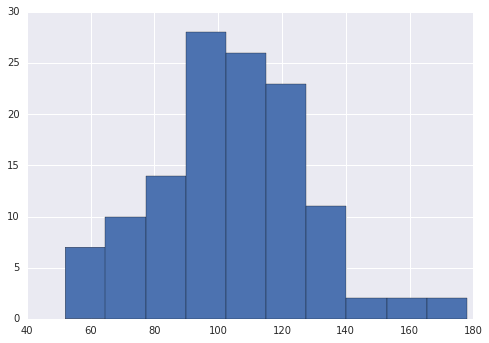

('X.shape: ', (125, 395))
('target.shape: ', (125,))
('y_train mean+-std= ', 101.52873563218391, 24.177559786297596)
('y_test mean+-std= ', 108.26315789473684, 23.354708085484162)
('test: pearson r,p:', 0.19071396130710777, 0.2514095453635987)
('test: explained_variance_score: ', 0.022557167115303534)
('train: pearson r,p:', 0.980572670809994, 6.53790980080663e-62)
('train: explained_variance_score: ', 0.894015220999456)


In [338]:
model_params={"learning_rate":0.005,"n_estimators": 600,"reg_alpha":5,
                  "gamma":1,"subsample":0.7,"max_depth":5}
Yname='GRACE Score'
test_size=0.3


r, expVar=prediction_short(Yname, model_params,test_size)

0
value distribution:


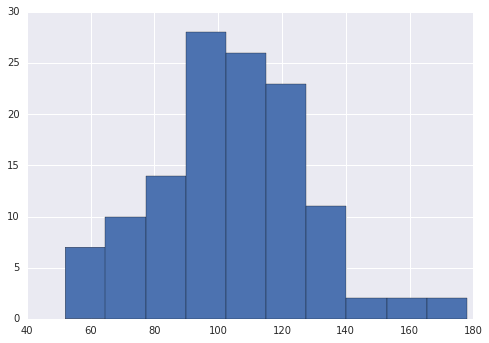

('X.shape: ', (125, 395))
('target.shape: ', (125,))
('y_train mean+-std= ', 103.57142857142857, 24.42554942283724)
('y_test mean+-std= ', 103.61538461538461, 21.270239230508828)
['berger_aa_1', 'count (templates)_max_1', 'count (templates)_std_1', 'd3Deletion_mean_0', 'd3Deletion_std_0', 'd5Deletion_std_1', 'frequencyCount (%)_max_0', 'frequencyCount (%)_mean_0', 'frequencyCount (%)_mean_1', 'frequencyCount (%)_std_0', 'jDeletion_mean_0', 'jDeletion_mean_1', 'jDeletion_std_0', 'jDeletion_std_1', 'max_nt_per_aa_1', 'mean_nt_per_aa_1', 'n1Insertion_max_1', 'n1Insertion_mean_1', 'n1Insertion_std_1', 'n2Insertion_mean_1', 'n2Insertion_std_0', 'simpson_aa_1', u'CMV_rel_cum_freq(perc)', u'HCV_rel_seq_count', u'HomoSapiens_rel_cum_freq(perc)', u'HomoSapiens_rel_seq_count', u'Lungcancer_rel_cum_freq(perc)', u'Lupus_rel_cum_freq(perc)', u'RSV_rel_cum_freq(perc)', u'RheumatoidArthritis_rel_cum_freq(perc)', u'RheumatoidArthritis_rel_seq_count', u'SIV_rel_cum_freq(perc)', 'PC2', 'PC3', 'PC8', 'V0

('test: pearson r,p:', 0.27883185192819526, 0.35625335314152623)
('test: explained_variance_score: ', 0.07737770385128029)
('train: pearson r,p:', 0.9882014510617572, 1.7832501625664683e-91)
('train: explained_variance_score: ', 0.9238912205197242)
5
('X.shape: ', (125, 395))
('target.shape: ', (125,))
('y_train mean+-std= ', 101.875, 22.84224196566567)
('y_test mean+-std= ', 118.23076923076923, 29.749380514989568)
['berger_aa_1', 'count (templates)_max_1', 'count (templates)_mean_1', 'count (templates)_std_1', 'd3Deletion_std_0', 'frequencyCount (%)_mean_0', 'jDeletion_mean_0', 'jDeletion_std_0', 'max_nt_per_aa_1', 'n1Insertion_max_0', 'n1Insertion_max_1', 'n1Insertion_std_1', 'n2Insertion_std_0', 'normSeqNums_per2000_NT_1', 'normSeqNums_per200_AA_1', 'shannon_aa_1', 'shannon_nt_1', 'simpson_aa_1', 'top10clonal_aa_1', 'vDeletion_mean_0', 'vDeletion_mean_1', u'BreastCancer_rel_cum_freq(perc)', u'HCV_rel_seq_count', u'HomoSapiens_rel_cum_freq(perc)', u'HomoSapiens_rel_seq_count', u'Lung

('X.shape: ', (125, 395))
('target.shape: ', (125,))
('y_train mean+-std= ', 102.75892857142857, 24.82778359985721)
('y_test mean+-std= ', 110.61538461538461, 14.465697710667476)
['berger_aa_1', 'cdr3Length_max_1', 'count (templates)_max_1', 'count (templates)_mean_1', 'count (templates)_std_1', 'd3Deletion_mean_0', 'd3Deletion_std_0', 'd5Deletion_mean_1', 'd5Deletion_std_1', 'frequencyCount (%)_mean_0', 'frequencyCount (%)_mean_1', 'jDeletion_mean_0', 'jDeletion_mean_1', 'jDeletion_std_0', 'jDeletion_std_1', 'max_nt_per_aa_1', 'mean_nt_per_aa_1', 'n1Insertion_mean_1', 'n1Insertion_std_1', 'n2Insertion_mean_1', 'n2Insertion_std_0', 'normSeqNums_per200_AA_1', 'simpson_aa_1', 'top10clonal_aa_1', u'CMV_rel_cum_freq(perc)', u'HCV_rel_seq_count', u'HomoSapiens_rel_cum_freq(perc)', u'HomoSapiens_rel_seq_count', u'Multiplesclerosis_rel_cum_freq(perc)', u'RSV_rel_cum_freq(perc)', u'RheumatoidArthritis_rel_seq_count', u'SIV_rel_cum_freq(perc)', u'WestNilevirus_rel_cum_freq(perc)', u'WestNilevir

In [353]:
model_params={"learning_rate":0.005,"n_estimators": 1000,"reg_alpha":0,
                  "gamma":0,"subsample":0.5,"max_depth":3}
Yname='GRACE Score'
bins=10
test_size=0.1
k=100

p_r_list=[]
expVar_list=[]
for i in range(10):
    print i
    if i==0:
        showDist=True
    else:
        showDist=False
    r, expVar=prediction_short(Yname, model_params,test_size,showDist,bins=bins,k=k)
    p_r_list.append(r)
    expVar_list.append(expVar)


print 'summary:'
print '********'
print ''
print ('p_r mean+- std: ',np.mean(p_r_list),np.std(p_r_list))
print ('expVar mean+- std: ',np.mean(expVar_list),np.std(expVar_list)) 

## check Ostial CX Disease score:

0
value distribution:


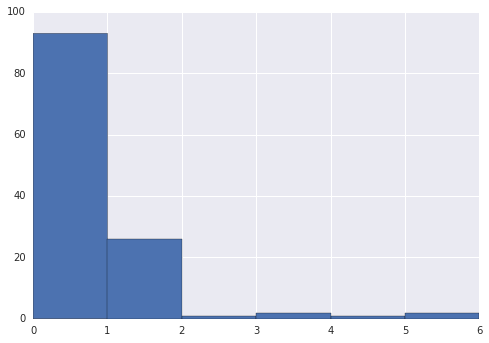

('X.shape: ', (125, 395))
('target.shape: ', (125,))
('y_train mean+-std= ', 0.39285714285714285, 0.9619531825166573)
('y_test mean+-std= ', 0.38461538461538464, 0.5063696835418333)
['cdr3Length_mean_0', 'cdr3Length_mean_1', 'cdr3Length_std_1', 'd5Deletion_mean_1', 'n1Insertion_std_1', 'n2Insertion_max_1', 'vDeletion_mean_0', u'Multiplesclerosis_rel_cum_freq(perc)', u'WestNilevirus_rel_cum_freq(perc)', u'WestNilevirus_rel_seq_count', u'YellowFeverVirus_rel_seq_count', 'V10_0', 'V02-01_0', 'V06-09_0', 'V10-01_0', 'V15-01_0', 'V27-01_0', 'J01-02_0', 'J01-06_0', 'J02-01_0', 'J02-02_0', 'J02-07_0', 'V05_J01_0', 'V07_J01_0', 'V09_J01_0', 'V11_J01_0', 'V15_J02_0', 'V19_J02_0', 'V23_J02_0', 'V27_J02_0', 'V29_J02_0', 'D01_J01-06_0', 'D02_J01-02_0', 'D02_J01-06_0', 'D02_J02-01_0', 'V02-01_1', 'V21-01_1', 'J01-06_1', 'J02-02_1', 'J02-04_1', 'J02-06_1', 'V02_J01_1', 'V02_J02_1', 'V19_J02_1', 'V21_J02_1', 'D01_J01-06_1', 'D01_J02-04_1', 'D01_J02-06_1', 'D02_J01-06_1', 'D02_J02-02_1']
('test: pears

('test: pearson r,p:', -0.08545737097132557, 0.7813335843277182)
('test: explained_variance_score: ', -0.42673708381522113)
('train: pearson r,p:', 0.9972488338535203, 3.78988880538921e-126)
('train: explained_variance_score: ', 0.9914915528085165)
7
('X.shape: ', (125, 395))
('target.shape: ', (125,))
('y_train mean+-std= ', 0.4107142857142857, 0.9637910452443409)
('y_test mean+-std= ', 0.23076923076923078, 0.4385290096535146)
['cdr3Length_mean_0', 'cdr3Length_mean_1', 'cdr3Length_std_1', 'd5Deletion_mean_1', 'n1Insertion_std_1', 'n2Insertion_max_1', 'vDeletion_mean_0', u'HTLV_rel_seq_count', u'Multiplesclerosis_rel_cum_freq(perc)', u'WestNilevirus_rel_cum_freq(perc)', u'WestNilevirus_rel_seq_count', u'YellowFeverVirus_rel_seq_count', 'V10_0', 'V02-01_0', 'V05-06_0', 'V06-07_0', 'V06-09_0', 'V10-01_0', 'V15-01_0', 'V20-01_0', 'V27-01_0', 'J01-02_0', 'J01-06_0', 'J02-01_0', 'J02-02_0', 'V02_J02_0', 'V07_J01_0', 'V09_J01_0', 'V11_J01_0', 'V15_J02_0', 'V19_J02_0', 'V23_J02_0', 'V27_J02_0

In [364]:
model_params={"learning_rate":0.01,"n_estimators": 1400,"reg_alpha":1,
                  "gamma":0,"subsample":0.7,"max_depth":9}
Yname='Ostial CX Disease'
bins=[0,1,2,3,4,5,6]
test_size=0.1
k=50

p_r_list=[]
expVar_list=[]
for i in range(10):
    print i
    if i==0:
        showDist=True
    else:
        showDist=False
    r, expVar=prediction_short(Yname, model_params,test_size,showDist,bins=bins,k=k)
    p_r_list.append(r)
    expVar_list.append(expVar)


print 'summary:'
print '********'
print ''
print ('p_r mean+- std: ',np.nanmean(p_r_list),np.nanstd(p_r_list))
print ('expVar mean+- std: ',np.nanmean(expVar_list),np.nanstd(expVar_list)) 

## check AST score:

0
value distribution:


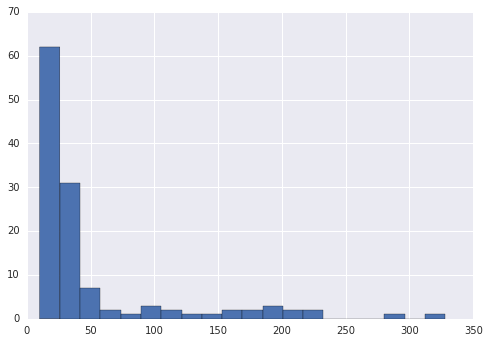

('X.shape: ', (123, 395))
('target.shape: ', (123,))
('y_train mean+-std= ', 50.5, 62.21400621087939)
('y_test mean+-std= ', 50.30769230769231, 54.79717847873893)
['berger_aa_1', 'cdr3Length_max_0', 'frequencyCount (%)_max_1', 'frequencyCount (%)_std_1', 'n2Insertion_max_0', 'n2Insertion_mean_0', u'Carcinoma_rel_seq_count', u'Celiacdisease_rel_cum_freq(perc)', u'totalAnnotatefreqs', 'V02-01_0', 'V05-08_0', 'V11-01_0', 'V13-01_0', 'V02_J02_0', 'V14_J02_0', 'V27_J01_0', 'D02_J02-05_0', 'V02-01_1', 'V15-01_1', 'V15_J02_1']
('test: pearson r,p:', 0.6909690554093338, 0.008915500624942457)
('test: explained_variance_score: ', 0.4769673435612798)
('train: pearson r,p:', 0.998060796631972, 4.46253392696746e-132)
('train: explained_variance_score: ', 0.9937680019971232)
1
('X.shape: ', (123, 395))
('target.shape: ', (123,))
('y_train mean+-std= ', 49.663636363636364, 62.50479281039355)
('y_test mean+-std= ', 57.38461538461539, 51.14283667914543)
['frequencyCount (%)_max_1', 'max_nt_per_aa_1', '

In [368]:
model_params={"learning_rate":0.05,"n_estimators": 200,"reg_alpha":5,
                  "gamma":0,"subsample":0.5,"max_depth":9}
Yname='AST'
bins=20
test_size=0.1
k=20

p_r_list=[]
expVar_list=[]
for i in range(10):
    print i
    if i==0:
        showDist=True
    else:
        showDist=False
    r, expVar=prediction_short(Yname, model_params,test_size,showDist,bins=bins,k=k)
    p_r_list.append(r)
    expVar_list.append(expVar)


print 'summary:'
print '********'
print ''
print ('p_r mean+- std: ',np.nanmean(p_r_list),np.nanstd(p_r_list))
print ('expVar mean+- std: ',np.nanmean(expVar_list),np.nanstd(expVar_list)) 

0
value distribution:


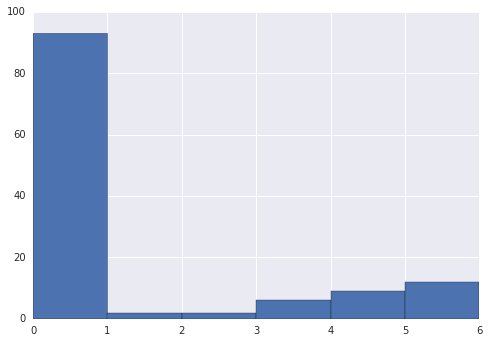

('X.shape: ', (124, 395))
('target.shape: ', (124,))
('y_train mean+-std= ', 0.8828828828828829, 1.7670660775767615)
('y_test mean+-std= ', 1.9230769230769231, 2.2898885875932358)
('test: pearson r,p:', 0.05551012721801081, 0.8570624660321005)
('test: explained_variance_score: ', -0.07719752537126601)
('train: pearson r,p:', 0.9960741499588631, 1.2969514259729216e-116)
('train: explained_variance_score: ', 0.9789170211945286)
1
('X.shape: ', (124, 395))
('target.shape: ', (124,))
('y_train mean+-std= ', 0.972972972972973, 1.8412419694792943)
('y_test mean+-std= ', 1.1538461538461537, 1.9513309067639728)
('test: pearson r,p:', -0.10744506425502866, 0.7268056436180792)
('test: explained_variance_score: ', -0.27832127159222675)
('train: pearson r,p:', 0.9965244013045613, 1.7171055091518605e-119)
('train: explained_variance_score: ', 0.982035630872394)
2
('X.shape: ', (124, 395))
('target.shape: ', (124,))
('y_train mean+-std= ', 1.045045045045045, 1.8944290931205607)
('y_test mean+-std= '

In [346]:
model_params={"learning_rate":0.005,"n_estimators": 1000,"reg_alpha":1,
                  "gamma":0,"subsample":0.7,"max_depth":7}
Yname='D1 Disease'
bins=[0,1,2,3,4,5,6]
test_size=0.1

p_r_list=[]
expVar_list=[]
for i in range(10):
    print i
    if i==0:
        showDist=True
    else:
        showDist=False
    r, expVar=prediction_short(Yname, model_params,test_size,showDist,bins=bins)
    p_r_list.append(r)
    expVar_list.append(expVar)


print 'summary:'
print '********'
print ''
print ('p_r mean+- std: ',np.mean(p_r_list),np.std(p_r_list))
print ('expVar mean+- std: ',np.mean(expVar_list),np.std(expVar_list))  
    

('pearson r,p:', (-0.0233978963811804, 0.8891063380312573))
('explained_variance_score: ', -0.08067668483729795)


# correct directory names for LVEF multi prediction

1. change names of all subdirectories
2. remove directory to its place in jaffar
3. run script again for plots and sum_df

In [15]:
curr_dir='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/TCR_real_data/predictions2/Cardio126_diseasePhenotypes/\
FinalCandidates/LVEF_XGB20_1999perms_multi/'

In [23]:
listdir(curr_dir)

['shuf1286_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf882_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf1632_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf1248_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf436_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf1655_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf451_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf345_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf1141_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf1941_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf322_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf758_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'argFile.txt',
 'shuf1126_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf1926_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf1592_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf796_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf117_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf1769_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf1313_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf4_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf917_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf170_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf1374_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf970_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf1460_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf664_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf1407_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf279_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf603_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf77_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf10_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf67_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf1470_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf674_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf1417_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf269_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf613_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf107_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf1779_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf1303_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf907_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro',
 'shuf160_XGBmulticlass20_gridSearc

In [21]:
dirs=listdir(curr_dir)

for i in range(2000):
    print i
#     try:
    os.rename(curr_dir+'shuf%s_logRegStrat_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByKappa/' %i,
         curr_dir+'shuf%s_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro/' %i)
#     except:
#         print 'couldnt execute for i=%s' %i


# for d in dirs:
#     if isdir(d):
#         d.

# 'shuf0_logRegStrat_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByKappa'
# 'shuf0_XGBmulticlass20_gridSearch_byRepFeatPCA10percVDJ0999PredictedAgeGender_optByF1macro'

0


OSError: [Errno 2] No such file or directory